# Purpose
- goal is to use DLC-estimated key points and define behavioral epochs
- data is from Alex F from Knowles lab, and we want to quanitfy:

1. time in light box (time visible)
    - nose only
    - nose and ears
    - nose and ears and butt
2. distance to edge IN REAL COORDINATES
    - adjust marked coordinates to real coordinates (50cm2 box)
    - get animal position relative to corners
3. #, timing, location of rearing events
4. #, timing, location of jumps


# imports

In [1]:
import numpy as np
import pandas as pd
import glob, os, csv
import matplotlib.pyplot as plt

In [2]:
import cv2

In [3]:
from sklearn.model_selection import train_test_split
from scipy.io import arff
import math

In [4]:
import itertools

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [6]:
from sklearn.ensemble import RandomForestClassifier

# functions

In [7]:
def reformat_df(df,likelihood_val,max_px_value,frame_limit_val,seconds,fps):
    new_df=pd.DataFrame()
    cols = np.unique([col[0] for col in df.columns])
    for col in cols:
        if "bodyparts" not in col:
            part = df[col]
            for idx in np.arange(0,len(part.x)):
                if part.likelihood[idx] < likelihood_val:
                    part.x[idx] = np.nan
                    part.y[idx] = np.nan
            if "box" not in col and "opening" not in col and "bodyparts" not in col:
                for idx in np.arange(0,len(part.x)):
                    second_idx = np.max([0,idx-1])
                    if abs(part.y[idx]-part.y[second_idx]) > max_px_value:
                        part.y[idx] = np.nan
                    elif abs(part.x[idx]-part.x[second_idx]) > max_px_value:
                        part.x[idx] = np.nan
                part.x = part.x.interpolate(limit=frame_limit_val)
                part.y = part.y.interpolate(limit=frame_limit_val)
                new_part = pd.concat({col:part},axis=1)
                if col == cols[1]:
                    new_df=new_part
                else:
                    new_df = pd.concat([new_df,new_part],axis=1)
            else:
                part.x = part.x.interpolate()
                part.x=part.x.rolling(seconds*fps,min_periods=1).median()
                part.y = part.y.interpolate()
                part.y=part.y.rolling(seconds*fps,min_periods=1).median()
                new_location = pd.concat({col:part},axis=1)
                new_df=pd.concat([new_df,new_location],axis=1)
            
    return new_df

In [8]:
def align_df(df):
    new_df=pd.DataFrame()
    # for each index, get the box coords, find transformation matrix, then apply it to all other points
    s1=[0,500]
    s2=[500,500]
    s3=[0,0]
    s4=[500,0]
    for idx in np.arange(0,len(df)):
        if idx%1000==0:
            print('at {} of {} rows'.format(idx,len(df)))
        # get box points
        p1=[df.box_bl.x[idx],df.box_bl.y[idx]] #0,500
        p2=[df.box_br.x[idx],df.box_br.y[idx]] #500,500
        p3=[df.box_tl.x[idx],df.box_tl.y[idx]] #0,0
        p4=[df.box_tr.x[idx],df.box_tr.y[idx]] #500,0
        # get transform matrix
        M = cv2.getPerspectiveTransform(np.float32([p1,p2,p3,p4]),np.float32([s1,s2,s3,s4]))
        # apply transform matrix to other points
        sub_df=df[df.index==idx].copy()
        for i in np.arange(0,len(sub_df.columns),3):
            p1_0=sub_df.iloc[0,i]
            p1_1=sub_df.iloc[0,i+1]
            if np.isnan(p1_0):
                p1_0_new=np.nan
                p1_1_new=np.nan
            else:
                # set points
                pts = np.array([[[p1_0,p1_1]]],dtype='float32')
                # use transform matrix to un-warp the points
                [p1_0_new,p1_1_new]=cv2.perspectiveTransform(pts,M)[0][0]
            sub_df.iloc[0,i]=p1_0_new
            sub_df.iloc[0,i+1]=p1_1_new
        new_df=pd.concat([new_df,sub_df],axis=0)
    return new_df

# load an example file, preprocess data (exclude outliers, smooth)

In [9]:
filename = "../../../AlexF/VID_20210925_134723DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000.csv"

In [10]:
num='VID_20210925_134723'

#filename = "../data/{}DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000.csv".format(num)
#filename = "/home/dennislab2/Desktop/videos/skok_alex_videos/5DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000.csv"
df = pd.read_csv(filename,header=[1,2])
df

bodyparts      box_tl                              box_tr              \
         coords           x           y likelihood            x           y   
0             0  605.690186  112.566269   0.998514  1422.758179  130.868729   
1             1  602.719910  112.679016   0.998509  1420.414551  131.275467   
2             2  602.701172  114.402534   0.998687  1419.799927  132.457672   
3             3  603.730774  114.894035   0.998613  1420.588867  132.530594   
4             4  603.454102  113.583282   0.999205  1422.154419  131.062836   
...         ...         ...         ...        ...          ...         ...   
25765     25765  603.119995  100.161270   0.999251  1429.601074  116.171844   
25766     25766  605.846375  100.323990   0.999135  1431.616089  116.099487   
25767     25767  606.506042  100.541878   0.998993  1432.324341  116.099411   
25768     25768  605.234619   98.927452   0.999275  1430.587402  114.357811   
25769     25769  602.843994   94.801529   0.997894  1428.796997  110.894730   

                      box_bl                         ... paw_left_front  \
      likelihood           x           y likelihood  ...     likelihood   
0       0.999204  594.486694  933.520935   0.999668  ...       0.001938   
1       0.999548  592.366577  933.889099   0.999467  ...       0.001885   
2       0.999571  594.004883  935.605591   0.999456  ...       0.001850   
3       0.999644  593.902649  934.587219   0.999508  ...       0.001865   
4       0.999513  594.474426  932.560059   0.999645  ...       0.001654   
...          ...         ...         ...        ...  ...            ...   
25765   0.999841  596.016785  927.579346   0.999381  ...       0.003026   
25766   0.999726  598.290222  927.280518   0.999226  ...       0.002298   
25767   0.999760  599.321045  926.837891   0.998642  ...       0.002335   
25768   0.999741  596.151306  925.667053   0.999399  ...       0.001844   
25769   0.999492  597.128662  922.359192   0.999095  ...       0.002023   

      paw_right_front                        paw_left_back              \
                    x           y likelihood             x           y   
0          589.272583  475.773407   0.002576    596.151794  463.886719   
1          589.388062  924.680359   0.002418    591.832153  465.855286   
2          588.472595  476.214478   0.002026    592.165222  466.879791   
3          588.937073  476.294556   0.002440    592.975525  466.971527   
4          602.101074  473.718323   0.002012    599.031311  466.768646   
...               ...         ...        ...           ...         ...   
25765     1231.274170  349.514587   0.001729    599.191162  460.845093   
25766     1435.280396  125.882698   0.001753    600.264954  460.552887   
25767      614.029053  570.292603   0.002303    613.219971  567.441345   
25768     1416.037598  924.603333   0.002546    598.863892  458.405029   
25769     1415.961182  923.702637   0.002505    598.559998  455.460480   

                 paw_right_back                         
      likelihood              x           y likelihood  
0       0.003638     597.841919  466.388550   0.012380  
1       0.002796    1424.473389  137.835236   0.011051  
2       0.002861    1424.068726  138.335800   0.015064  
3       0.002519    1424.746460  138.401199   0.013763  
4       0.004997     600.959595  470.936401   0.013085  
...          ...            ...         ...        ...  
25765   0.003268     613.968201  570.072205   0.004724  
25766   0.003003    1436.701904  121.611145   0.006933  
25767   0.003588     613.262390  570.018005   0.009183  
25768   0.005919     613.755066  569.563477   0.004369  
25769   0.008102     613.792053  568.282166   0.005081  

[25770 rows x 46 columns]

In [13]:
filename.split('/')[-1][0:19]

'VID_20210925_134723'

In [12]:
num='VID_20210925_134723'

In [14]:
tst=times[times.File_name=='VID_20220927_104102']
tst=tst.reset_index()
tst

NameError: name 'times' is not defined

In [96]:
tst.drop(columns=['index'])

,Assay_No,File_name,Start_time_in_seconds,End_time_in_seconds,Notes
0,263,VID_20220927_104102,0,600,NaN


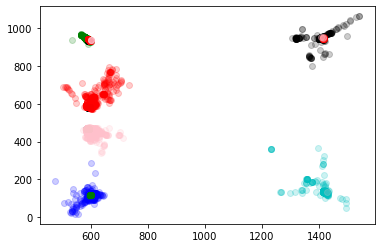

In [15]:
a=0
b=-1
plt.scatter(df.box_tl["x"][a:b],df.box_tl["y"][a:b],c='b',alpha=0.2)
plt.scatter(df.box_tr["x"][a:b],df.box_tr["y"][a:b],c='c',alpha=0.2)
plt.scatter(df.box_bl["x"][a:b],df.box_bl["y"][a:b],c='g',alpha=0.2)
plt.scatter(df.box_br["x"][a:b],df.box_br["y"][a:b],c='k',alpha=0.2)
plt.scatter(df.opening_bottom["x"][a:b],df.opening_bottom["y"][a:b],c='r',alpha=0.2)
plt.scatter(df.opening_top["x"][a:b],df.opening_top["y"][a:b],c='pink',alpha=0.2)
plt.show()

## which rolling window is "good" at discarding random jumps in assignment but still capturing the slides?

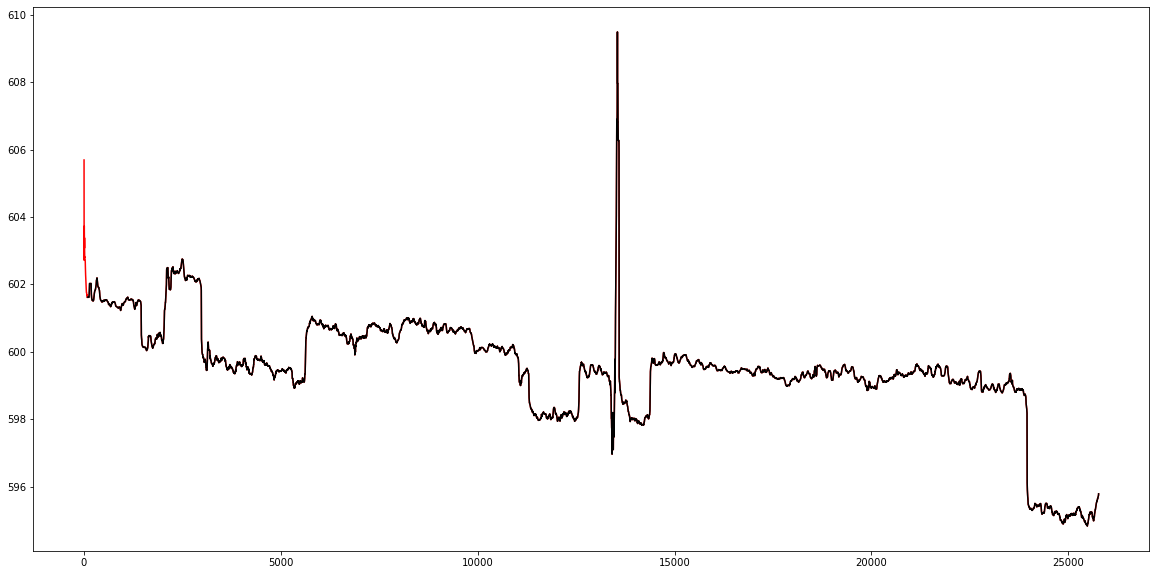

In [14]:
s = df.box_tl["x"]
seconds=3
fps=30
plt.figure(figsize=(20,10))
plt.plot(s.rolling(seconds*fps,min_periods=1).median(),c='r')
plt.plot(s.rolling(seconds*fps).median(),c='k')
#plt.xlim((0,100))
plt.show()

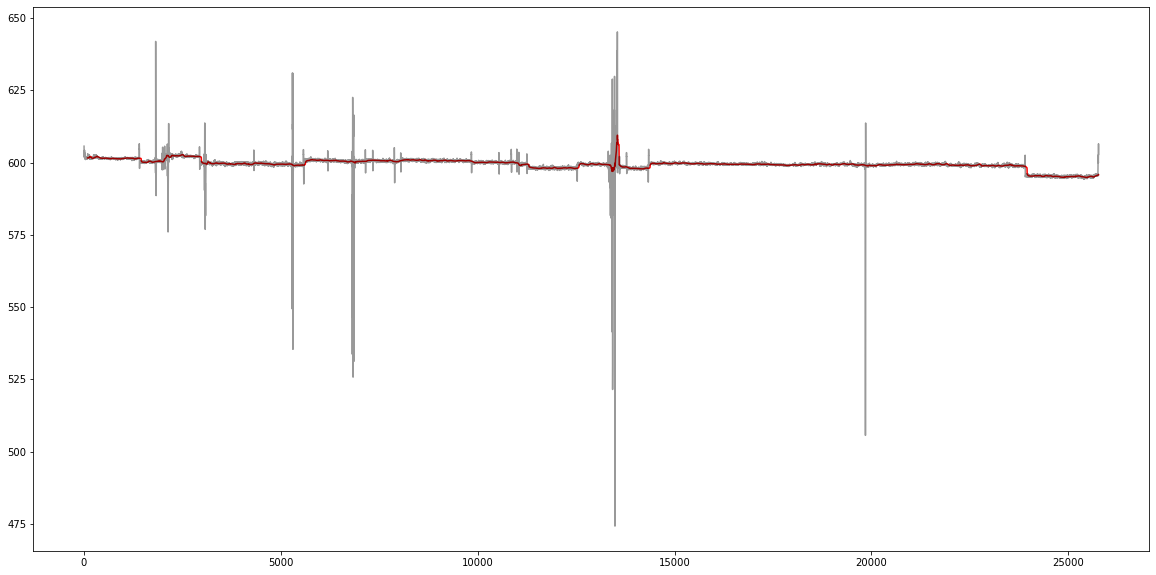

In [15]:
s = df.box_tl["x"]
plt.figure(figsize=(20,10))
plt.plot(s.rolling(seconds*fps).median(),c='r')
plt.plot(s,c='k',alpha=0.4)
plt.show()

### what adjustments do we need for body parts?

In [16]:
new_df=reformat_df(df,0.9,1000,15,3,30)

C:\Users\dennise\AppData\Local\Temp\ipykernel_2240\3168813908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df=reformat_df(df,0.9,1000,15,3,30)
C:\Users\dennise\Anaconda3\envs\fieldwork_2021\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [17]:
total_frames=[]
num_entrances=[]
first_frame_in_center=[]
frames_with_nose=[]
frames_with_head=[]
frames_with_body=[]
frames_within_50mm=[]
fraction_frames_within_50mm=[]
fraction_LIGHT_frames_within_50mm=[]
fraction_LIGHT_frames_in_center=[]

box_bl                              box_br                         \
                x           y likelihood            x           y likelihood   
0      594.486694  933.520935   0.999668  1407.037598  942.941589   0.993497   
1      593.426636  933.705017   0.999467  1405.883179  942.758270   0.991115   
2      594.004883  933.889099   0.999456  1405.653931  942.941589   0.994242   
3      593.953766  934.238159   0.999508  1405.912292  942.904633   0.992683   
4      594.004883  933.889099   0.999645  1406.170654  942.867676   0.976002   
...           ...         ...        ...          ...         ...        ...   
25765  586.248718  942.390625   0.999381  1408.981873  950.058441   0.992932   
25766  586.251373  942.358246   0.999226  1408.986023  950.002747   0.988079   
25767  586.257599  942.312103   0.998642  1408.990295  949.952148   0.982898   
25768  586.266571  942.286926   0.999399  1408.995850  949.940430   0.996220   
25769  586.272858  942.286926   0.999095  1409.005798  949.940430   0.993697   

           box_tl                              box_tr  ... paw_right_back  \
                x           y likelihood            x  ...     likelihood   
0      605.690186  112.566269   0.998514  1422.758179  ...       0.012380   
1      604.205048  112.622643   0.998509  1421.586365  ...       0.011051   
2      602.719910  112.679016   0.998687  1420.414551  ...       0.015064   
3      603.225342  113.540775   0.998613  1420.501709  ...       0.013763   
4      603.454102  113.583282   0.999205  1420.588867  ...       0.013085   
...           ...         ...        ...          ...  ...            ...   
25765  595.745911  112.080246   0.999251  1421.065735  ...       0.004724   
25766  595.750427  112.080246   0.999135  1421.074585  ...       0.006933   
25767  595.754028  112.065350   0.998993  1421.088684  ...       0.009183   
25768  595.772400  112.055233   0.999275  1421.110901  ...       0.004369   
25769  595.795837  112.046276   0.997894  1421.120422  ...       0.005081   

      paw_right_front                tail_base                tail_tip      \
                    x   y likelihood         x   y likelihood        x   y   
0                 NaN NaN   0.002576       NaN NaN   0.004226      NaN NaN   
1                 NaN NaN   0.002418       NaN NaN   0.005394      NaN NaN   
2                 NaN NaN   0.002026       NaN NaN   0.003556      NaN NaN   
3                 NaN NaN   0.002440       NaN NaN   0.003215      NaN NaN   
4                 NaN NaN   0.002012       NaN NaN   0.003482      NaN NaN   
...               ...  ..        ...       ...  ..        ...      ...  ..   
25765             NaN NaN   0.001729       NaN NaN   0.005230      NaN NaN   
25766             NaN NaN   0.001753       NaN NaN   0.006444      NaN NaN   
25767             NaN NaN   0.002303       NaN NaN   0.005618      NaN NaN   
25768             NaN NaN   0.002546       NaN NaN   0.005097      NaN NaN   
25769             NaN NaN   0.002505       NaN NaN   0.007814      NaN NaN   

                  
      likelihood  
0       0.030472  
1       0.087720  
2       0.063736  
3       0.035512  
4       0.022456  
...          ...  
25765   0.128017  
25766   0.091034  
25767   0.071708  
25768   0.139558  
25769   0.161247  

[25770 rows x 45 columns]

In [ ]:
os.mkdir

In [18]:
#filename[:-4]+"_adj.csv"
new_df.to_csv(filename[:-4]+"_adj.csv")

In [19]:
new_df = pd.read_csv(filename[:-4]+"_adj.csv",header=[0,1],index_col=0)

In [20]:
new_df

box_bl                              box_br                         \
                x           y likelihood            x           y likelihood   
0      594.486694  933.520935   0.999668  1407.037598  942.941589   0.993497   
1      593.426636  933.705017   0.999467  1405.883179  942.758270   0.991115   
2      594.004883  933.889099   0.999456  1405.653931  942.941589   0.994242   
3      593.953766  934.238159   0.999508  1405.912292  942.904633   0.992683   
4      594.004883  933.889099   0.999645  1406.170654  942.867676   0.976002   
...           ...         ...        ...          ...         ...        ...   
25765  586.248718  942.390625   0.999381  1408.981873  950.058441   0.992932   
25766  586.251373  942.358246   0.999226  1408.986023  950.002747   0.988079   
25767  586.257599  942.312103   0.998642  1408.990295  949.952148   0.982898   
25768  586.266571  942.286926   0.999399  1408.995850  949.940430   0.996220   
25769  586.272858  942.286926   0.999095  1409.005798  949.940430   0.993697   

           box_tl                              box_tr  ... paw_right_back  \
                x           y likelihood            x  ...     likelihood   
0      605.690186  112.566269   0.998514  1422.758179  ...       0.012380   
1      604.205048  112.622643   0.998509  1421.586365  ...       0.011051   
2      602.719910  112.679016   0.998687  1420.414551  ...       0.015064   
3      603.225342  113.540775   0.998613  1420.501709  ...       0.013763   
4      603.454102  113.583282   0.999205  1420.588867  ...       0.013085   
...           ...         ...        ...          ...  ...            ...   
25765  595.745911  112.080246   0.999251  1421.065735  ...       0.004724   
25766  595.750427  112.080246   0.999135  1421.074585  ...       0.006933   
25767  595.754028  112.065350   0.998993  1421.088684  ...       0.009183   
25768  595.772400  112.055233   0.999275  1421.110901  ...       0.004369   
25769  595.795837  112.046276   0.997894  1421.120422  ...       0.005081   

      paw_right_front                tail_base                tail_tip      \
                    x   y likelihood         x   y likelihood        x   y   
0                 NaN NaN   0.002576       NaN NaN   0.004226      NaN NaN   
1                 NaN NaN   0.002418       NaN NaN   0.005394      NaN NaN   
2                 NaN NaN   0.002026       NaN NaN   0.003556      NaN NaN   
3                 NaN NaN   0.002440       NaN NaN   0.003215      NaN NaN   
4                 NaN NaN   0.002012       NaN NaN   0.003482      NaN NaN   
...               ...  ..        ...       ...  ..        ...      ...  ..   
25765             NaN NaN   0.001729       NaN NaN   0.005230      NaN NaN   
25766             NaN NaN   0.001753       NaN NaN   0.006444      NaN NaN   
25767             NaN NaN   0.002303       NaN NaN   0.005618      NaN NaN   
25768             NaN NaN   0.002546       NaN NaN   0.005097      NaN NaN   
25769             NaN NaN   0.002505       NaN NaN   0.007814      NaN NaN   

                  
      likelihood  
0       0.030472  
1       0.087720  
2       0.063736  
3       0.035512  
4       0.022456  
...          ...  
25765   0.128017  
25766   0.091034  
25767   0.071708  
25768   0.139558  
25769   0.161247  

[25770 rows x 45 columns]

In [22]:
part = new_df.box_tl

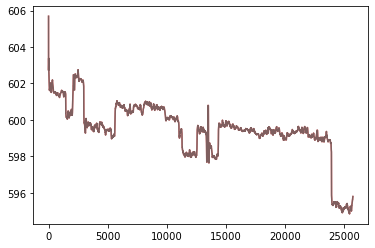

In [23]:
#plt.figure(figsize=(20,10))
#plt.plot(part.y,c='k')
plt.plot(part.x.interpolate(limit=15),c='r',alpha=1)
plt.plot(part.x.interpolate(limit=5),c='c',alpha=0.5)
plt.show()

# preprocessing thoughts 

let's say for now,
- for corners, rolling median of 90 (frames, 3 sec)
- interpolating between nans limit = 15 (.5 sec)

### ~TODO~ Done:
1. first, apply the above lessons to an entire dataframe, save it
2. should make box, and find region (in px) that correspond to 5 cm from edge (of the 50x50cm box)
3. extract useful info
    a. how much time did the animal spend visible?
        i. just nose?
        ii. nose + ears?
        iii. nose + ears + tail base?

In [48]:
?plt.savefig

## affine transform of points to correct for sliding FOV

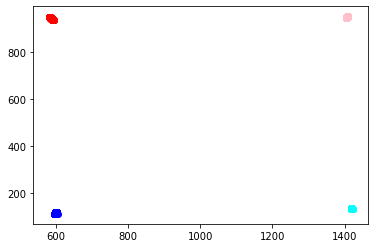

In [24]:
plt.scatter(new_df.box_bl['x'],new_df.box_bl['y'],c='r') #0,500mm
plt.scatter(new_df.box_br['x'],new_df.box_br['y'],c='pink') #500,500mm
plt.scatter(new_df.box_tl['x'],new_df.box_tl['y'],c='b') #0,0mm
plt.scatter(new_df.box_tr['x'],new_df.box_tr['y'],c='cyan') #500,0mm

In [25]:
s1=[0,500]
s2=[500,500]
s3=[0,0]
s4=[500,0]
idx=1000
p1=[new_df.box_bl.x[idx],new_df.box_bl.y[idx]] #0,500
p2=[new_df.box_br.x[idx],new_df.box_br.y[idx]] #500,500
p3=[new_df.box_tl.x[idx],new_df.box_tl.y[idx]] #0,0
p4=[new_df.box_tr.x[idx],new_df.box_tr.y[idx]] #500,0
print(p1,p2,p3,p4)
print(s1,s2,s3,s4)

[591.3690185546875, 937.3073120117188] [1405.7431640625, 945.81591796875] [601.4089965820312, 116.61967468261716] [1418.8646850585938, 135.2613525390625]
[0, 500] [500, 500] [0, 0] [500, 0]


In [26]:
# get a transform matrix
A2 = cv2.getPerspectiveTransform(np.float32([p1,p2,p3,p4]),np.float32([s1,s2,s3,s4]))

# set points
pts = np.array([[p1]],dtype='float32')

# use transform matrix to un-warp the points
cv2.perspectiveTransform(pts,A2)

array([[[  0., 500.]]], dtype=float32)

In [27]:
aligned_df=align_df(new_df)
aligned_df

at 0 of 25770 rows
at 1000 of 25770 rows
at 2000 of 25770 rows
at 3000 of 25770 rows
at 4000 of 25770 rows
at 5000 of 25770 rows
at 6000 of 25770 rows
at 7000 of 25770 rows
at 8000 of 25770 rows
at 9000 of 25770 rows
at 10000 of 25770 rows
at 11000 of 25770 rows
at 12000 of 25770 rows
at 13000 of 25770 rows
at 14000 of 25770 rows
at 15000 of 25770 rows
at 16000 of 25770 rows
at 17000 of 25770 rows
at 18000 of 25770 rows
at 19000 of 25770 rows
at 20000 of 25770 rows
at 21000 of 25770 rows
at 22000 of 25770 rows
at 23000 of 25770 rows
at 24000 of 25770 rows
at 25000 of 25770 rows


box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0      0.000000e+00  500.0   0.999668  500.0  500.0   0.993497  5.733686e-14   
1      5.772567e-14  500.0   0.999467  500.0  500.0   0.991115  1.147304e-13   
2      0.000000e+00  500.0   0.999456  500.0  500.0   0.994242  0.000000e+00   
3     -5.776971e-14  500.0   0.999508  500.0  500.0   0.992683  5.738170e-14   
4      0.000000e+00  500.0   0.999645  500.0  500.0   0.976002  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
25765  0.000000e+00  500.0   0.999381  500.0  500.0   0.992932  0.000000e+00   
25766  5.760141e-14  500.0   0.999226  500.0  500.0   0.988079  5.740943e-14   
25767  0.000000e+00  500.0   0.998642  500.0  500.0   0.982898  0.000000e+00   
25768  0.000000e+00  500.0   0.999399  500.0  500.0   0.996220 -5.740945e-14   
25769  5.760173e-14  500.0   0.999095  500.0  500.0   0.993697  5.740957e-14   

                               box_tr  ... paw_right_back paw_right_front      \
                  y likelihood      x  ...     likelihood               x   y   
0      0.000000e+00   0.998514  500.0  ...       0.012380             NaN NaN   
1      7.170649e-15   0.998509  500.0  ...       0.011051             NaN NaN   
2     -7.172473e-15   0.998687  500.0  ...       0.015064             NaN NaN   
3     -7.172712e-15   0.998613  500.0  ...       0.013763             NaN NaN   
4      0.000000e+00   0.999205  500.0  ...       0.013085             NaN NaN   
...             ...        ...    ...  ...            ...             ...  ..   
25765  0.000000e+00   0.999251  500.0  ...       0.004724             NaN NaN   
25766  7.176178e-15   0.999135  500.0  ...       0.006933             NaN NaN   
25767  1.435250e-14   0.998993  500.0  ...       0.009183             NaN NaN   
25768  0.000000e+00   0.999275  500.0  ...       0.004369             NaN NaN   
25769  0.000000e+00   0.997894  500.0  ...       0.005081             NaN NaN   

                 tail_base                tail_tip                 
      likelihood         x   y likelihood        x   y likelihood  
0       0.002576       NaN NaN   0.004226      NaN NaN   0.030472  
1       0.002418       NaN NaN   0.005394      NaN NaN   0.087720  
2       0.002026       NaN NaN   0.003556      NaN NaN   0.063736  
3       0.002440       NaN NaN   0.003215      NaN NaN   0.035512  
4       0.002012       NaN NaN   0.003482      NaN NaN   0.022456  
...          ...       ...  ..        ...      ...  ..        ...  
25765   0.001729       NaN NaN   0.005230      NaN NaN   0.128017  
25766   0.001753       NaN NaN   0.006444      NaN NaN   0.091034  
25767   0.002303       NaN NaN   0.005618      NaN NaN   0.071708  
25768   0.002546       NaN NaN   0.005097      NaN NaN   0.139558  
25769   0.002505       NaN NaN   0.007814      NaN NaN   0.161247  

[25770 rows x 45 columns]

In [29]:
aligned_df.to_csv(filename[:-4]+"_aligned.csv")

### save out aligned data

In [30]:
#aligned_df.to_csv(filename[:-4]+"_aligned.csv")
aligned_df=pd.read_csv(filename[:-4]+"_aligned.csv",index_col=0,header=[0,1])

### let's see what the data look like after adjustment

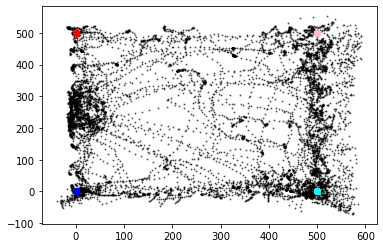

In [31]:
plt.scatter(aligned_df.nose['x'],aligned_df.nose['y'],c='k',s=1,alpha=0.5)
plt.scatter(aligned_df.box_bl['x'],aligned_df.box_bl['y'],c='r')
plt.scatter(aligned_df.box_br['x'],aligned_df.box_br['y'],c='pink')
plt.scatter(aligned_df.box_tl['x'],aligned_df.box_tl['y'],c='b')
plt.scatter(aligned_df.box_tr['x'],aligned_df.box_tr['y'],c='cyan')
plt.show()

In [32]:
nose_df = aligned_df.nose
nose_df

,x,y,likelihood
0,NaN,NaN,0.003495
1,NaN,NaN,0.004142
2,NaN,NaN,0.003391
3,NaN,NaN,0.002887
4,NaN,NaN,0.002850
...,...,...,...
25765,NaN,NaN,0.005655
25766,NaN,NaN,0.004744
25767,NaN,NaN,0.005832
25768,NaN,NaN,0.005637


### how much time did the animal spend in the box?


In [34]:
#aligned_df = pd.read_csv('../data/{}DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000_aligned.csv'.format(num), index_col=0, header=[0,1])


In [35]:
17965/(29.93*60)

10.003897984185322

In [36]:
nose_vals = ~np.isnan(aligned_df.nose['x'])
ear_l_vals = ~np.isnan(aligned_df.ear_left['x'])
ear_r_vals = ~np.isnan(aligned_df.ear_right['x'])
tail_vals = ~np.isnan(aligned_df.tail_base['x'])

print("frames with nose: {}".format(np.sum(nose_vals)))
frames_with_nose = np.sum(nose_vals)
print("frames with nose and ears: {}".format(np.sum(nose_vals*ear_l_vals*ear_r_vals)))
print("frames with nose and ears and tail: {}".format(np.sum(nose_vals*ear_l_vals*ear_r_vals*tail_vals)))
print("total frames {}".format(len(nose_vals)))

frames with nose: 11386
frames with nose and ears: 10995
frames with nose and ears and tail: 10550
total frames 25770


C:\Users\dennise\Anaconda3\envs\fieldwork_2021\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


### how much time did it spend within 50mm of the 500mm^2 walls?


In [37]:
# can just use adj px values > 450 and < 50 (further vals are outside walls, but include jumps and rears which we do want to include)
nose_df=aligned_df.nose
#nose_df=nose_df[~np.isnan(nose_df.x)].reset_index()
nose_df['within50mm']=0
for idx in nose_df.index:
    xval=nose_df.x[idx]
    yval=nose_df.y[idx]
    if xval < 50 or xval > 450 or yval < 50 or yval > 450:
        nose_df.iloc[idx,3]=1
summed_val=np.sum(nose_df.within50mm)
print("frames with nose within 50mm of edge {}".format(summed_val))
print("fraction of frames with nose within 50mm of edge {}".format(summed_val/len(nose_df)))
print("fraction of frames where animal is inside the box AND within 50mm of an edge {}".format(summed_val/frames_with_nose))
print("fraction of frames where animal is inside and in the center (further than 50mm from an edge): {}".format((frames_with_nose-summed_val)/frames_with_nose))

C:\Users\dennise\AppData\Local\Temp\ipykernel_2240\3598521612.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nose_df['within50mm']=0
C:\Users\dennise\Anaconda3\envs\fieldwork_2021\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


frames with nose within 50mm of edge 9526
fraction of frames with nose within 50mm of edge 0.3696546371750097
fraction of frames where animal is inside the box AND within 50mm of an edge 0.8366414895485684
fraction of frames where animal is inside and in the center (further than 50mm from an edge): 0.16335851045143157


In [38]:
#number of entrances
# Alex might have additionals

### find first frame where it enters the 'center' of the box

In [39]:
tstdf=nose_df[~np.isnan(nose_df.x)]
tstdf=tstdf[tstdf.within50mm<1]
print("first frame in center (> 50mm from edge): {}".format(tstdf.index[0]))

first frame in center (> 50mm from edge): 567


In [40]:
# plot points in adjusted space

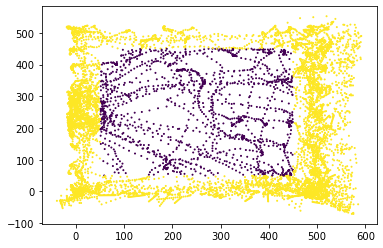

In [41]:
plt.scatter(nose_df.x,nose_df.y,c=nose_df.within50mm,s=1)

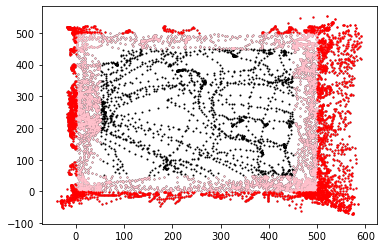

In [42]:
plt.scatter(nose_df.x,nose_df.y,s=1,c='k')
plt.scatter(nose_df.x[nose_df.x<50],nose_df.y[nose_df.x<50],c='pink',s=1)

plt.scatter(nose_df.x[nose_df.x>450],nose_df.y[nose_df.x>450],c='pink',s=1)

plt.scatter(nose_df.x[nose_df.y<50],nose_df.y[nose_df.y<50],c='pink',s=1)
plt.scatter(nose_df.x[nose_df.y>450],nose_df.y[nose_df.y>450],c='pink',s=1)

plt.scatter(nose_df.x[nose_df.x<0],nose_df.y[nose_df.x<0],c='r',s=1)
plt.scatter(nose_df.x[nose_df.x>500],nose_df.y[nose_df.x>500],c='r',s=1)
plt.scatter(nose_df.x[nose_df.y<0],nose_df.y[nose_df.y<0],c='r',s=1)
plt.scatter(nose_df.x[nose_df.y>500],nose_df.y[nose_df.y>500],c='r',s=1)

## jump and rear classifications

In [43]:
filename

'../../../AlexF/VID_20210925_134723DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000.csv'

In [44]:
num

'VID_20210925_134723'

In [ ]:
## 

In [45]:
Alex_annot_filename = '../data/boris_events_{}_just_jumps.csv'.format(num)
annots=pd.read_csv(Alex_annot_filename,header=0)
aligned_df=pd.read_csv(filename[:-4]+"_aligned_dists.csv",header=[0,1],index_col=0)
annots

FileNotFoundError: [Errno 2] No such file or directory: '../data/boris_events_VID_20210925_134723_just_jumps.csv'

In [20]:
aligned_df

box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0     -5.727973e-14  500.0   0.999648  500.0  500.0   0.999597 -1.143288e-13   
1      0.000000e+00  500.0   0.999717  500.0  500.0   0.999780 -5.717598e-14   
2     -5.753928e-14  500.0   0.999794  500.0  500.0   0.999789  0.000000e+00   
3      5.755104e-14  500.0   0.999755  500.0  500.0   0.999719  0.000000e+00   
4      0.000000e+00  500.0   0.999596  500.0  500.0   0.999642  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
17960  5.401259e-14  500.0   0.999954  500.0  500.0   0.999766  0.000000e+00   
17961  5.401210e-14  500.0   0.999939  500.0  500.0   0.999612  0.000000e+00   
17962 -5.401287e-14  500.0   0.999946  500.0  500.0   0.999694 -1.647637e-13   
17963  0.000000e+00  500.0   0.999961  500.0  500.0   0.999666  0.000000e+00   
17964  5.400505e-14  500.0   0.999955  500.0  500.0   0.999664  5.491859e-14   

                               box_tr  ...   tail_tip          dists  \
                  y likelihood      x  ... likelihood nose_ear_right   
0      3.572775e-14   0.999919  500.0  ...   0.068285            NaN   
1     -5.002898e-14   0.999920  500.0  ...   0.095745            NaN   
2      7.154222e-15   0.999872  500.0  ...   0.066341            NaN   
3      0.000000e+00   0.999915  500.0  ...   0.103802            NaN   
4      0.000000e+00   0.999895  500.0  ...   0.065217            NaN   
...             ...        ...    ...  ...        ...            ...   
17960 -2.746206e-14   0.999926  500.0  ...   0.008596            NaN   
17961  0.000000e+00   0.999944  500.0  ...   0.010931            NaN   
17962 -1.373031e-14   0.999953  500.0  ...   0.007687            NaN   
17963 -1.373015e-14   0.999929  500.0  ...   0.009762            NaN   
17964  1.372965e-14   0.999945  500.0  ...   0.007127            NaN   

                                                            \
      nose_ear_left nose_paw_left_back nose_paw_left_front   
0               NaN                NaN                 NaN   
1               NaN                NaN                 NaN   
2               NaN                NaN                 NaN   
3               NaN                NaN                 NaN   
4               NaN                NaN                 NaN   
...             ...                ...                 ...   
17960           NaN                NaN                 NaN   
17961           NaN                NaN                 NaN   
17962           NaN                NaN                 NaN   
17963           NaN                NaN                 NaN   
17964           NaN                NaN                 NaN   

                                                                             \
      nose_paw_right_back nose_paw_right_front nose_tail_tip nose_tail_base   
0                     NaN                  NaN           NaN            NaN   
1                     NaN                  NaN           NaN            NaN   
2                     NaN                  NaN           NaN            NaN   
3                     NaN                  NaN           NaN            NaN   
4                     NaN                  NaN           NaN            NaN   
...                   ...                  ...           ...            ...   
17960                 NaN                  NaN           NaN            NaN   
17961                 NaN                  NaN           NaN            NaN   
17962                 NaN                  NaN           NaN            NaN   
17963                 NaN                  NaN           NaN            NaN   
17964                 NaN                  NaN           NaN            NaN   

                    speed  
      Unnamed: 54_level_1  
0                     0.0  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  
... 

In [27]:
annots['frame_start']=annots.Time_start_new*annots.FPS
annots['frame_end']=annots.Time_end_new*annots.FPS

In [60]:
times = pd.read_csv('../../../AlexF/start_times_videos.csv')
times

,Assay_No,File_name,Start_time_in_seconds,End_time_in_seconds,Notes
0,2,VID_20210923_095848,63,663,NaN
1,3,VID_20210923_102806,89,689,NaN
2,4,VID_20210923_110223,117,717,NaN
3,5,VID_20210923_115732,6,606,NaN
4,6,VID_20210923_124032,72,672,NaN
...,...,...,...,...,...
258,263,VID_20220927_104102,0,600,NaN
259,264,VID_20220927_110316,0,600,NaN
260,265,VID_20220927_112914,0,600,NaN
261,266,VID_20220927_114936,0,600,NaN


In [68]:
times = pd.read_csv('../../../AlexF/start_times_videos.csv')

for file_name in times.File_name:
    print(os.path.isfile(os.path.join('../../../AlexF',file_name+"DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000.csv")))

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False

In [ ]:
'../../../AlexF/VID_20210925_134723DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000_adj.csv'

### first predicted entry

In [24]:
first_predicted=aligned_df[aligned_df.nose.x>-100].index[0]
first_annotated = annots.Time[0]
print("first frame with predicted entry {}".format(first_predicted))
print("first annotated entry {}".format(first_annotated))
print("first annotated entry * FPS {}".format(first_annotated*annots.FPS[0]))
print("offset in frames {}".format(first_annotated*annots.FPS[0]-first_predicted))
offset = first_annotated-(first_predicted/annots.FPS[0])
print("offset in seconds {}".format(offset))
annots['adj_time']=annots.Time-offset
annots['adj_frame']=annots.adj_time*annots.FPS

first frame with predicted entry 234
first annotated entry 47.056
first annotated entry * FPS 1408.38608
offset in frames 1174.38608
offset in seconds 39.23775743401269


box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0      0.000000e+00  500.0   0.999668  500.0  500.0   0.993497  5.733686e-14   
1      5.772567e-14  500.0   0.999467  500.0  500.0   0.991115  1.147304e-13   
2      0.000000e+00  500.0   0.999456  500.0  500.0   0.994242  0.000000e+00   
3     -5.776971e-14  500.0   0.999508  500.0  500.0   0.992683  5.738170e-14   
4      0.000000e+00  500.0   0.999645  500.0  500.0   0.976002  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
25765  0.000000e+00  500.0   0.999381  500.0  500.0   0.992932  0.000000e+00   
25766  5.760141e-14  500.0   0.999226  500.0  500.0   0.988079  5.740943e-14   
25767  0.000000e+00  500.0   0.998642  500.0  500.0   0.982898  0.000000e+00   
25768  0.000000e+00  500.0   0.999399  500.0  500.0   0.996220 -5.740945e-14   
25769  5.760173e-14  500.0   0.999095  500.0  500.0   0.993697  5.740957e-14   

                               box_tr  ... paw_right_front                 \
                  y likelihood      x  ...               x   y likelihood   
0      0.000000e+00   0.998514  500.0  ...             NaN NaN   0.002576   
1      7.170649e-15   0.998509  500.0  ...             NaN NaN   0.002418   
2     -7.172473e-15   0.998687  500.0  ...             NaN NaN   0.002026   
3     -7.172712e-15   0.998613  500.0  ...             NaN NaN   0.002440   
4      0.000000e+00   0.999205  500.0  ...             NaN NaN   0.002012   
...             ...        ...    ...  ...             ...  ..        ...   
25765  0.000000e+00   0.999251  500.0  ...             NaN NaN   0.001729   
25766  7.176178e-15   0.999135  500.0  ...             NaN NaN   0.001753   
25767  1.435250e-14   0.998993  500.0  ...             NaN NaN   0.002303   
25768  0.000000e+00   0.999275  500.0  ...             NaN NaN   0.002546   
25769  0.000000e+00   0.997894  500.0  ...             NaN NaN   0.002505   

      tail_base                tail_tip                in_box  
              x   y likelihood        x   y likelihood         
0           NaN NaN   0.004226      NaN NaN   0.030472    0.0  
1           NaN NaN   0.005394      NaN NaN   0.087720    0.0  
2           NaN NaN   0.003556      NaN NaN   0.063736    0.0  
3           NaN NaN   0.003215      NaN NaN   0.035512    0.0  
4           NaN NaN   0.003482      NaN NaN   0.022456    0.0  
...         ...  ..        ...      ...  ..        ...    ...  
25765       NaN NaN   0.005230      NaN NaN   0.128017    0.0  
25766       NaN NaN   0.006444      NaN NaN   0.091034    0.0  
25767       NaN NaN   0.005618      NaN NaN   0.071708    0.0  
25768       NaN NaN   0.005097      NaN NaN   0.139558    0.0  
25769       NaN NaN   0.007814      NaN NaN   0.161247    0.0  

[25770 rows x 46 columns]

In [57]:
aligned_df['in_box']=float(0)
aligned_df['light_bout_num']=float(0)
bout_num=0
for idx in aligned_df.index:
    if np.isnan(aligned_df.nose.x[idx]):
        aligned_df.iloc[idx,-2]=0
        aligned_df.iloc[idx,-1]=0
    elif aligned_df.iloc[idx-1,-2]==0:
        bout_num+=1
        aligned_df.iloc[idx,-2]=1
        aligned_df.iloc[idx,-1]=bout_num
    else:
        aligned_df.iloc[idx,-2]=1
        aligned_df.iloc[idx,-1]=bout_num

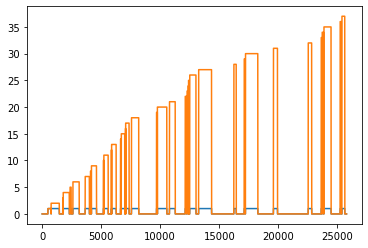

In [59]:
plt.plot(aligned_df.in_box)
plt.plot(aligned_df.light_bout_num)
plt.show()

In [51]:
annots_in_box=annots[annots.Behavior=='Light'].reset_index()
aligned_df['annots','in_light']=float(0)
aligned_df

NameError: name 'annots' is not defined

In [ ]:
fps=annots.FPS[0]
aligned_df['annots','in_light']=0

for idx in np.arange(0,len(annots_in_box),2):
    print(annots_in_box.Time[idx])
    val1=int(round(annots_in_box.adj_frame[idx]))
    val2=int(round(annots_in_box.adj_frame[idx+1]))
    aligned_df.iloc[val1:val2,-1]=1
aligned_df

### plot the should-be-aligned data

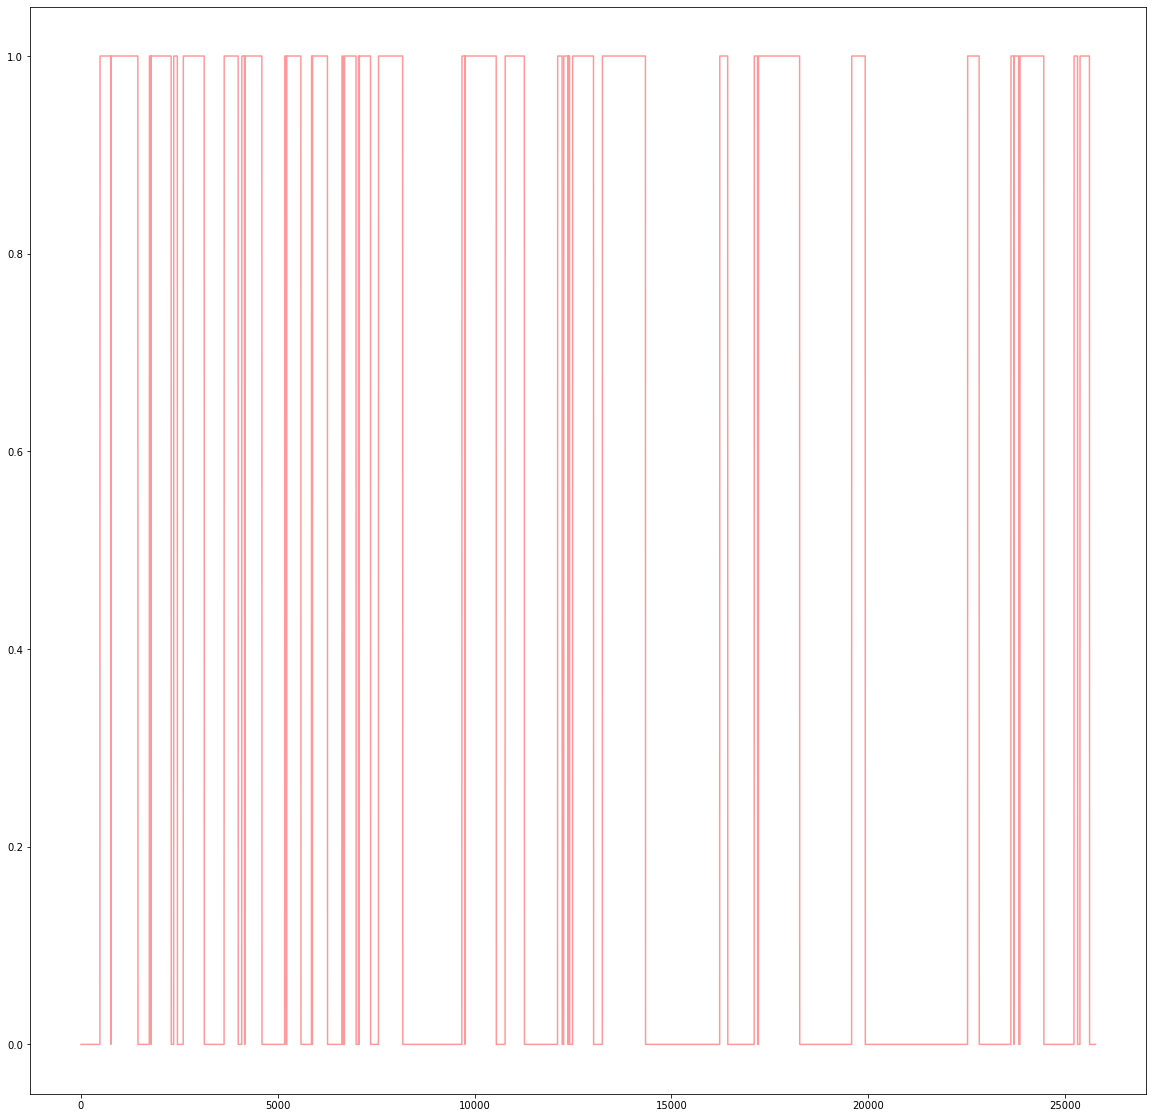

In [52]:
start=400
inc=400
plt.figure(figsize=(20,20))
plt.plot(aligned_df.in_box,'r',alpha=.4)
#plt.plot(aligned_df.annots.in_light,'k',alpha=.4)
#plt.xlim([start,start+inc])

## building a classifier, random forest

### ANNOTATION IMPORT

In [91]:
annots_rears=pd.DataFrame()

for idx in annots.index:
    if "rear" in annots.Behavior[idx]:
        annots_rears=pd.concat([annots_rears,annots[annots.index==idx]],axis=0)

annots_rears=annots_rears.reset_index().drop(columns='index')

In [92]:
## add anns to df
aligned_df['annots','rear_supported']=float(0)
aligned_df['annots','rear_unsupported']=float(0)

In [93]:
for idx in np.arange(0,len(annots_rears),2):
    val1=int(round(annots_rears.adj_frame[idx]))
    val2=int(round(annots_rears.adj_frame[idx+1]))
    if "nsupported" in annots_rears.Behavior[idx]:
        #unsupported
        aligned_df.iloc[val1:val2,-1]=1
    else:
        #supported
        aligned_df.iloc[val1:val2,-2]=1

AttributeError: 'DataFrame' object has no attribute 'adj_frame'

In [50]:
# make subsetted dataframe with just jumps
annots_jumps=pd.DataFrame()

for idx in annots.index:
    if "ump" in annots.Behavior[idx]:
        annots_jumps=pd.concat([annots_jumps,annots[annots.index==idx]],axis=0)

annots_jumps=annots_jumps.reset_index().drop(columns='index')
aligned_df['annots','jumps']=float(0)
for idx in np.arange(0,len(annots_jumps)):
    val1=int(round(annots_jumps.adj_frame[idx]-1))
    val2=int(round(annots_jumps.adj_frame[idx]+5))
    aligned_df.iloc[val1:val2,-1]=1
aligned_df

box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0      0.000000e+00  500.0   0.999807  500.0  500.0   0.999425  0.000000e+00   
1      0.000000e+00  500.0   0.999832  500.0  500.0   0.999105  0.000000e+00   
2      0.000000e+00  500.0   0.999849  500.0  500.0   0.998960  5.693558e-14   
3      0.000000e+00  500.0   0.999859  500.0  500.0   0.999381  1.138557e-13   
4      5.760037e-14  500.0   0.999788  500.0  500.0   0.999701  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
17959  0.000000e+00  500.0   0.999835  500.0  500.0   0.999936  5.755170e-14   
17960  5.812110e-14  500.0   0.999849  500.0  500.0   0.999925  5.755086e-14   
17961  0.000000e+00  500.0   0.999856  500.0  500.0   0.999932  5.755119e-14   
17962  0.000000e+00  500.0   0.999817  500.0  500.0   0.999890  5.755169e-14   
17963  1.162559e-13  500.0   0.999817  500.0  500.0   0.999934  0.000000e+00   

                               box_tr  ...              dists  \
                  y likelihood      x  ... nose_paw_left_back   
0      7.117104e-15   0.999978  500.0  ...                NaN   
1      7.117825e-15   0.999977  500.0  ...                NaN   
2     -7.116947e-15   0.999986  500.0  ...                NaN   
3      0.000000e+00   0.999985  500.0  ...                NaN   
4      7.115562e-15   0.999982  500.0  ...                NaN   
...             ...        ...    ...  ...                ...   
17959  1.438793e-14   0.999932  500.0  ...                NaN   
17960  0.000000e+00   0.999925  500.0  ...                NaN   
17961  0.000000e+00   0.999916  500.0  ...                NaN   
17962 -7.193961e-15   0.999898  500.0  ...                NaN   
17963  0.000000e+00   0.999898  500.0  ...                NaN   

                                                                    \
      nose_paw_left_front nose_paw_right_back nose_paw_right_front   
0                     NaN                 NaN                  NaN   
1                     NaN                 NaN                  NaN   
2                     NaN                 NaN                  NaN   
3                     NaN                 NaN                  NaN   
4                     NaN                 NaN                  NaN   
...                   ...                 ...                  ...   
17959                 NaN                 NaN                  NaN   
17960                 NaN           39.456385                  NaN   
17961                 NaN           40.143779                  NaN   
17962                 NaN           40.469550                  NaN   
17963                 NaN           39.421078                  NaN   

                                                 speed         annots  \
      nose_tail_tip nose_tail_base Unnamed: 54_level_1 rear_supported   
0               NaN            NaN            0.000000            0.0   
1               NaN            NaN                 NaN            0.0   
2               NaN            NaN                 NaN            0.0   
3               NaN            NaN                 NaN            0.0   
4               NaN            NaN                 NaN            0.0   
...             ...            ...                 ...            ...   
17959           NaN            NaN            4.387804            0.0   
17960           NaN            NaN            5.448547            0.0   
17961           NaN            NaN            2.683241            0.0   
17962           NaN            NaN            1.656397            0.0   
17963           NaN            NaN            0.654721            0.0   

                              
      rear_unsupported jumps  
0                  0.0   0.0  
1                  0.0   0.0  
2                  0.0   0.0  
3                  0.0   0.0  
4                  0.0   0.0  
...                ...   ...  
17959            

In [89]:
aligned_df['dists','nose_ear_right']=float(0)
aligned_df['dists','nose_ear_left']=float(0)
aligned_df['dists','nose_paw_left_back']=float(0)
aligned_df['dists','nose_paw_left_front']=float(0)
aligned_df['dists','nose_paw_right_back']=float(0)
aligned_df['dists','nose_paw_right_front']=float(0)
aligned_df['dists','nose_tail_tip']=float(0)
aligned_df['dists','nose_tail_base']=float(0)
aligned_df['speed']=float(0)

for idx in aligned_df.index:
    if idx%1000==0:
        print("on idx {} of {}".format(idx,aligned_df.index[-1]))
    rel_idx = idx-aligned_df.index[0]
    if rel_idx > 0:
        speed = math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.nose.x[idx-1],aligned_df.nose.y[idx-1]])
    else:
        speed=0
    aligned_df.iloc[rel_idx,-1]=speed
    aligned_df.iloc[rel_idx,-2]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.tail_base.x[idx],aligned_df.tail_base.y[idx]])
    aligned_df.iloc[rel_idx,-3]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.tail_tip.x[idx],aligned_df.tail_tip.y[idx]])
    aligned_df.iloc[rel_idx,-4]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_right_front.x[idx],aligned_df.paw_right_front.y[idx]])
    aligned_df.iloc[rel_idx,-5]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_right_back.x[idx],aligned_df.paw_right_back.y[idx]])
    aligned_df.iloc[rel_idx,-6]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_left_front.x[idx],aligned_df.paw_left_front.y[idx]])
    aligned_df.iloc[rel_idx,-7]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_left_back.x[idx],aligned_df.paw_left_back.y[idx]])
    aligned_df.iloc[rel_idx,-8]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.ear_left.x[idx],aligned_df.ear_left.y[idx]])
    aligned_df.iloc[rel_idx,-9]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.ear_right.x[idx],aligned_df.ear_right.y[idx]])
    
    
aligned_df

on idx 0 of 14420
on idx 1000 of 14420
on idx 2000 of 14420
on idx 3000 of 14420
on idx 4000 of 14420
on idx 5000 of 14420
on idx 6000 of 14420
on idx 7000 of 14420
on idx 8000 of 14420
on idx 9000 of 14420
on idx 10000 of 14420
on idx 11000 of 14420
on idx 12000 of 14420
on idx 13000 of 14420
on idx 14000 of 14420


box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0     -2.243271e-13  500.0   0.999694  500.0  500.0   0.998650 -3.389650e-13   
1     -1.119552e-13  500.0   0.999684  500.0  500.0   0.998445 -1.128578e-13   
2      0.000000e+00  500.0   0.999678  500.0  500.0   0.998847  0.000000e+00   
3      2.234336e-13  500.0   0.999718  500.0  500.0   0.998613  1.127140e-13   
4      0.000000e+00  500.0   0.999707  500.0  500.0   0.998745  1.127083e-13   
...             ...    ...        ...    ...    ...        ...           ...   
14416  0.000000e+00  500.0   0.999753  500.0  500.0   0.198465  0.000000e+00   
14417  0.000000e+00  500.0   0.999752  500.0  500.0   0.189202  0.000000e+00   
14418  0.000000e+00  500.0   0.999631  500.0  500.0   0.205819  2.051288e-13   
14419 -1.992907e-13  500.0   0.999740  500.0  500.0   0.184471 -2.051146e-13   
14420  0.000000e+00  500.0   0.999767  500.0  500.0   0.163525  0.000000e+00   

                               box_tr  ...   tail_tip          dists  \
                  y likelihood      x  ... likelihood nose_ear_right   
0      0.000000e+00   0.999966  500.0  ...   0.017635            NaN   
1     -1.128578e-13   0.999971  500.0  ...   0.014370            NaN   
2     -5.635446e-14   0.999968  500.0  ...   0.014855            NaN   
3     -5.635702e-14   0.999967  500.0  ...   0.014145            NaN   
4      0.000000e+00   0.999967  500.0  ...   0.010465            NaN   
...             ...        ...    ...  ...        ...            ...   
14416 -1.025832e-13   0.999979  500.0  ...   0.995354      29.007572   
14417 -5.128718e-14   0.999979  500.0  ...   0.995839      29.776314   
14418  0.000000e+00   0.999980  500.0  ...   0.996005      29.799916   
14419 -5.127864e-14   0.999985  500.0  ...   0.996222      30.591426   
14420 -5.127537e-14   0.999985  500.0  ...   0.995707      29.019459   

                                                            \
      nose_ear_left nose_paw_left_back nose_paw_left_front   
0               NaN                NaN                 NaN   
1               NaN                NaN                 NaN   
2               NaN                NaN                 NaN   
3               NaN                NaN                 NaN   
4               NaN                NaN                 NaN   
...             ...                ...                 ...   
14416     28.323011                NaN                 NaN   
14417     29.883591                NaN                 NaN   
14418     29.799977                NaN                 NaN   
14419     30.462051                NaN                 NaN   
14420     29.305721                NaN                 NaN   

                                                                             \
      nose_paw_right_back nose_paw_right_front nose_tail_tip nose_tail_base   
0                     NaN                  NaN           NaN            NaN   
1                     NaN                  NaN           NaN            NaN   
2                     NaN                  NaN           NaN            NaN   
3                     NaN                  NaN           NaN            NaN   
4                     NaN                  NaN           NaN            NaN   
...                   ...                  ...           ...            ...   
14416                 NaN                  NaN    130.543273      73.514611   
14417                 NaN                  NaN    131.014353      74.163434   
14418                 NaN                  NaN    131.174925      74.198612   
14419                 NaN                  NaN    132.896570      75.614895   
14420                 NaN                  NaN    131.523610      73.799962   

          speed  
                 
0      0.000000  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
14416  2.701311  
14417  1.405295  
14418  0.182430  
14

In [114]:
aligned_df.to_csv(filename[:-4]+"_aligned_dists.csv")

# new data format from Alex

In [232]:
aligned_df = pd.read_csv('../data/33DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000_aligned_dists.csv',header=[0,1])

In [234]:
aligned_df=aligned_df.drop(columns=aligned_df.columns[0])

In [235]:
aligned_df['annots','jump'] = float(0)
for idx in annots.index:
    val1=int(round(annots.frame_start[idx]))
    val2=int(round(annots.frame_end[idx]))
    aligned_df.iloc[val1:val2,-1]=1

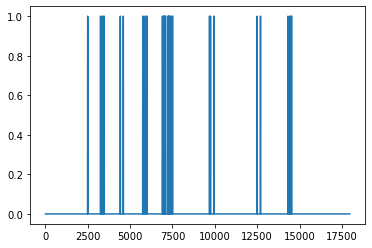

In [236]:
plt.plot(aligned_df.annots['jump'])

In [240]:
filename

'../data/33DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000.csv'

In [241]:
aligned_df.to_csv(filename[:-4]+"_with_jumps.csv")

In [244]:
aligned_df = pd.read_csv('../data/33DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000_with_jumps.csv'.format(num), index_col=0, header=[0,1])
np.nansum(aligned_df.annots['jump'])

449.0

In [245]:
for num in [33,6,39,40,5]:
    filename='../data/{}DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000.csv'.format(num)
    Alex_annot_filename = '../data/boris_events_{}_just_jumps.csv'.format(num)
    annots=pd.read_csv(Alex_annot_filename,header=0)
    annots['frame_start']=annots.Time_start_new*annots.FPS
    annots['frame_end']=annots.Time_end_new*annots.FPS
    aligned_df=pd.read_csv(filename[:-4]+"_aligned_dists.csv",header=[0,1],index_col=0)
    aligned_df['annots','jump'] = float(0)
    for idx in annots.index:
        val1=int(round(annots.frame_start[idx]))
        val2=int(round(annots.frame_end[idx]))
        aligned_df.iloc[val1:val2,-1]=1
    aligned_df.to_csv(filename[:-4]+"_with_jumps.csv")

NameError: name 'clf' is not defined

### make training and test data

In [246]:
#aligned_df_39=aligned_df.copy()
#new_aligned_df=aligned_df.copy()
#old_aligned_df=pd.read_csv('/Users/dennise/Downloads/5DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000_aligned_dists.csv',index_col=0,header=[0,1])

In [247]:
#aligned_df.to_csv(filename[:-4]+'_aligned_dists_annots.csv')

In [248]:
num=5

In [254]:
all_aligned_dfs=pd.DataFrame()
for num in [33,6,39,40,5]:
    aligned_df=pd.read_csv('../data/{}DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000_with_jumps.csv'.format(num),index_col=0,header=[0,1])
    all_aligned_dfs=pd.concat([all_aligned_dfs,aligned_df])
all_aligned_dfs=all_aligned_dfs.reset_index()
all_aligned_dfs=all_aligned_dfs.drop(columns=['index'])

C:\Users\dennise\Anaconda3\envs\fieldwork_2021\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [288]:
all_aligned_dfs.columns

MultiIndex([(         'annots',             'in_light'),
            (         'annots',                 'jump'),
            (         'annots',                'jumps'),
            (         'annots',       'rear_supported'),
            (         'annots',     'rear_unsupported'),
            (         'box_bl',           'likelihood'),
            (         'box_bl',                    'x'),
            (         'box_bl',                    'y'),
            (         'box_br',           'likelihood'),
            (         'box_br',                    'x'),
            (         'box_br',                    'y'),
            (         'box_tl',           'likelihood'),
            (         'box_tl',                    'x'),
            (         'box_tl',                    'y'),
            (         'box_tr',           'likelihood'),
            (         'box_tr',                    'x'),
            (         'box_tr',                    'y'),
            (          'dists',

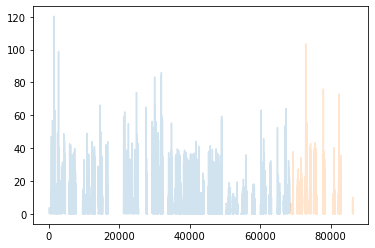

In [339]:
plt.plot(df_for_training.speed,alpha=0.2)
plt.plot(df_for_training.other,alpha=0.2)

In [345]:
for idx in df_for_training.index:
    if np.isnan(df_for_training.speed[idx]):
        speed[idx]=df_for_training.other[idx]
    else:
        speed[idx]=df_for_training.speed[idx]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

3283
3284
3285
3286
3287
3288
3289
3290
3291
3292
3293
3294
3295
3296
3297
3298
3299
3300
3301
3302
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482


6721
6722
6723
6724
6725
6726
6727
6728
6729
6730
6731
6732
6733
6734
6735
6736
6737
6738
6739
6740
6741
6742
6743
6744
6745
6746
6747
6748
6749
6750
6751
6752
6753
6754
6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920


10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
1026

13369
13370
13371
13372
13373
13374
13375
13376
13377
13378
13379
13380
13381
13382
13383
13384
13385
13386
13387
13388
13389
13390
13391
13392
13393
13394
13395
13396
13397
13398
13399
13400
13401
13402
13403
13404
13405
13406
13407
13408
13409
13410
13411
13412
13413
13414
13415
13416
13417
13418
13419
13420
13421
13422
13423
13424
13425
13426
13427
13428
13429
13430
13431
13432
13433
13434
13435
13436
13437
13438
13439
13440
13441
13442
13443
13444
13445
13446
13447
13448
13449
13450
13451
13452
13453
13454
13455
13456
13457
13458
13459
13460
13461
13462
13463
13464
13465
13466
13467
13468
13469
13470
13471
13472
13473
13474
13475
13476
13477
13478
13479
13480
13481
13482
13483
13484
13485
13486
13487
13488
13489
13490
13491
13492
13493
13494
13495
13496
13497
13498
13499
13500
13501
13502
13503
13504
13505
13506
13507
13508
13509
13510
13511
13512
13513
13514
13515
13516
13517
13518
13519
13520
13521
13522
13523
13524
13525
13526
13527
13528
13529
13530
13531
13532
13533
13534
1353

16781
16782
16783
16784
16785
16786
16787
16788
16789
16790
16791
16792
16793
16794
16795
16796
16797
16798
16799
16800
16801
16802
16803
16804
16805
16806
16807
16808
16809
16810
16811
16812
16813
16814
16815
16816
16817
16818
16819
16820
16821
16822
16823
16824
16825
16826
16827
16828
16829
16830
16831
16832
16833
16834
16835
16836
16837
16838
16839
16840
16841
16842
16843
16844
16845
16846
16847
16848
16849
16850
16851
16852
16853
16854
16855
16856
16857
16858
16859
16860
16861
16862
16863
16864
16865
16866
16867
16868
16869
16870
16871
16872
16873
16874
16875
16876
16877
16878
16879
16880
16881
16882
16883
16884
16885
16886
16887
16888
16889
16890
16891
16892
16893
16894
16895
16896
16897
16898
16899
16900
16901
16902
16903
16904
16905
16906
16907
16908
16909
16910
16911
16912
16913
16914
16915
16916
16917
16918
16919
16920
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
1694

20243
20244
20245
20246
20247
20248
20249
20250
20251
20252
20253
20254
20255
20256
20257
20258
20259
20260
20261
20262
20263
20264
20265
20266
20267
20268
20269
20270
20271
20272
20273
20274
20275
20276
20277
20278
20279
20280
20281
20282
20283
20284
20285
20286
20287
20288
20289
20290
20291
20292
20293
20294
20295
20296
20297
20298
20299
20300
20301
20302
20303
20304
20305
20306
20307
20308
20309
20310
20311
20312
20313
20314
20315
20316
20317
20318
20319
20320
20321
20322
20323
20324
20325
20326
20327
20328
20329
20330
20331
20332
20333
20334
20335
20336
20337
20338
20339
20340
20341
20342
20343
20344
20345
20346
20347
20348
20349
20350
20351
20352
20353
20354
20355
20356
20357
20358
20359
20360
20361
20362
20363
20364
20365
20366
20367
20368
20369
20370
20371
20372
20373
20374
20375
20376
20377
20378
20379
20380
20381
20382
20383
20384
20385
20386
20387
20388
20389
20390
20391
20392
20393
20394
20395
20396
20397
20398
20399
20400
20401
20402
20403
20404
20405
20406
20407
20408
2040

23280
23281
23282
23283
23284
23285
23286
23287
23288
23289
23290
23291
23292
23293
23294
23295
23296
23297
23298
23299
23300
23301
23302
23303
23304
23305
23306
23307
23308
23309
23310
23311
23312
23313
23314
23315
23316
23317
23318
23319
23320
23321
23322
23323
23324
23325
23326
23327
23328
23329
23330
23331
23332
23333
23334
23335
23336
23337
23338
23339
23340
23341
23342
23343
23344
23345
23346
23347
23348
23349
23350
23351
23352
23353
23354
23355
23356
23357
23358
23359
23360
23361
23362
23363
23364
23365
23366
23367
23368
23369
23370
23371
23372
23373
23374
23375
23376
23377
23378
23379
23380
23381
23382
23383
23384
23385
23386
23387
23388
23389
23390
23391
23392
23393
23394
23395
23396
23397
23398
23399
23400
23401
23402
23403
23404
23405
23406
23407
23408
23409
23410
23411
23412
23413
23414
23415
23416
23417
23418
23419
23420
23421
23422
23423
23424
23425
23426
23427
23428
23429
23430
23431
23432
23433
23434
23435
23436
23437
23438
23439
23440
23441
23442
23443
23444
23445
2344

26780
26781
26782
26783
26784
26785
26786
26787
26788
26789
26790
26791
26792
26793
26794
26795
26796
26797
26798
26799
26800
26801
26802
26803
26804
26805
26806
26807
26808
26809
26810
26811
26812
26813
26814
26815
26816
26817
26818
26819
26820
26821
26822
26823
26824
26825
26826
26827
26828
26829
26830
26831
26832
26833
26834
26835
26836
26837
26838
26839
26840
26841
26842
26843
26844
26845
26846
26847
26848
26849
26850
26851
26852
26853
26854
26855
26856
26857
26858
26859
26860
26861
26862
26863
26864
26865
26866
26867
26868
26869
26870
26871
26872
26873
26874
26875
26876
26877
26878
26879
26880
26881
26882
26883
26884
26885
26886
26887
26888
26889
26890
26891
26892
26893
26894
26895
26896
26897
26898
26899
26900
26901
26902
26903
26904
26905
26906
26907
26908
26909
26910
26911
26912
26913
26914
26915
26916
26917
26918
26919
26920
26921
26922
26923
26924
26925
26926
26927
26928
26929
26930
26931
26932
26933
26934
26935
26936
26937
26938
26939
26940
26941
26942
26943
26944
26945
2694

30080
30081
30082
30083
30084
30085
30086
30087
30088
30089
30090
30091
30092
30093
30094
30095
30096
30097
30098
30099
30100
30101
30102
30103
30104
30105
30106
30107
30108
30109
30110
30111
30112
30113
30114
30115
30116
30117
30118
30119
30120
30121
30122
30123
30124
30125
30126
30127
30128
30129
30130
30131
30132
30133
30134
30135
30136
30137
30138
30139
30140
30141
30142
30143
30144
30145
30146
30147
30148
30149
30150
30151
30152
30153
30154
30155
30156
30157
30158
30159
30160
30161
30162
30163
30164
30165
30166
30167
30168
30169
30170
30171
30172
30173
30174
30175
30176
30177
30178
30179
30180
30181
30182
30183
30184
30185
30186
30187
30188
30189
30190
30191
30192
30193
30194
30195
30196
30197
30198
30199
30200
30201
30202
30203
30204
30205
30206
30207
30208
30209
30210
30211
30212
30213
30214
30215
30216
30217
30218
30219
30220
30221
30222
30223
30224
30225
30226
30227
30228
30229
30230
30231
30232
30233
30234
30235
30236
30237
30238
30239
30240
30241
30242
30243
30244
30245
3024

33436
33437
33438
33439
33440
33441
33442
33443
33444
33445
33446
33447
33448
33449
33450
33451
33452
33453
33454
33455
33456
33457
33458
33459
33460
33461
33462
33463
33464
33465
33466
33467
33468
33469
33470
33471
33472
33473
33474
33475
33476
33477
33478
33479
33480
33481
33482
33483
33484
33485
33486
33487
33488
33489
33490
33491
33492
33493
33494
33495
33496
33497
33498
33499
33500
33501
33502
33503
33504
33505
33506
33507
33508
33509
33510
33511
33512
33513
33514
33515
33516
33517
33518
33519
33520
33521
33522
33523
33524
33525
33526
33527
33528
33529
33530
33531
33532
33533
33534
33535
33536
33537
33538
33539
33540
33541
33542
33543
33544
33545
33546
33547
33548
33549
33550
33551
33552
33553
33554
33555
33556
33557
33558
33559
33560
33561
33562
33563
33564
33565
33566
33567
33568
33569
33570
33571
33572
33573
33574
33575
33576
33577
33578
33579
33580
33581
33582
33583
33584
33585
33586
33587
33588
33589
33590
33591
33592
33593
33594
33595
33596
33597
33598
33599
33600
33601
3360

36278
36279
36280
36281
36282
36283
36284
36285
36286
36287
36288
36289
36290
36291
36292
36293
36294
36295
36296
36297
36298
36299
36300
36301
36302
36303
36304
36305
36306
36307
36308
36309
36310
36311
36312
36313
36314
36315
36316
36317
36318
36319
36320
36321
36322
36323
36324
36325
36326
36327
36328
36329
36330
36331
36332
36333
36334
36335
36336
36337
36338
36339
36340
36341
36342
36343
36344
36345
36346
36347
36348
36349
36350
36351
36352
36353
36354
36355
36356
36357
36358
36359
36360
36361
36362
36363
36364
36365
36366
36367
36368
36369
36370
36371
36372
36373
36374
36375
36376
36377
36378
36379
36380
36381
36382
36383
36384
36385
36386
36387
36388
36389
36390
36391
36392
36393
36394
36395
36396
36397
36398
36399
36400
36401
36402
36403
36404
36405
36406
36407
36408
36409
36410
36411
36412
36413
36414
36415
36416
36417
36418
36419
36420
36421
36422
36423
36424
36425
36426
36427
36428
36429
36430
36431
36432
36433
36434
36435
36436
36437
36438
36439
36440
36441
36442
36443
3644

39278
39279
39280
39281
39282
39283
39284
39285
39286
39287
39288
39289
39290
39291
39292
39293
39294
39295
39296
39297
39298
39299
39300
39301
39302
39303
39304
39305
39306
39307
39308
39309
39310
39311
39312
39313
39314
39315
39316
39317
39318
39319
39320
39321
39322
39323
39324
39325
39326
39327
39328
39329
39330
39331
39332
39333
39334
39335
39336
39337
39338
39339
39340
39341
39342
39343
39344
39345
39346
39347
39348
39349
39350
39351
39352
39353
39354
39355
39356
39357
39358
39359
39360
39361
39362
39363
39364
39365
39366
39367
39368
39369
39370
39371
39372
39373
39374
39375
39376
39377
39378
39379
39380
39381
39382
39383
39384
39385
39386
39387
39388
39389
39390
39391
39392
39393
39394
39395
39396
39397
39398
39399
39400
39401
39402
39403
39404
39405
39406
39407
39408
39409
39410
39411
39412
39413
39414
39415
39416
39417
39418
39419
39420
39421
39422
39423
39424
39425
39426
39427
39428
39429
39430
39431
39432
39433
39434
39435
39436
39437
39438
39439
39440
39441
39442
39443
3944

42481
42482
42483
42484
42485
42486
42487
42488
42489
42490
42491
42492
42493
42494
42495
42496
42497
42498
42499
42500
42501
42502
42503
42504
42505
42506
42507
42508
42509
42510
42511
42512
42513
42514
42515
42516
42517
42518
42519
42520
42521
42522
42523
42524
42525
42526
42527
42528
42529
42530
42531
42532
42533
42534
42535
42536
42537
42538
42539
42540
42541
42542
42543
42544
42545
42546
42547
42548
42549
42550
42551
42552
42553
42554
42555
42556
42557
42558
42559
42560
42561
42562
42563
42564
42565
42566
42567
42568
42569
42570
42571
42572
42573
42574
42575
42576
42577
42578
42579
42580
42581
42582
42583
42584
42585
42586
42587
42588
42589
42590
42591
42592
42593
42594
42595
42596
42597
42598
42599
42600
42601
42602
42603
42604
42605
42606
42607
42608
42609
42610
42611
42612
42613
42614
42615
42616
42617
42618
42619
42620
42621
42622
42623
42624
42625
42626
42627
42628
42629
42630
42631
42632
42633
42634
42635
42636
42637
42638
42639
42640
42641
42642
42643
42644
42645
42646
4264

45676
45677
45678
45679
45680
45681
45682
45683
45684
45685
45686
45687
45688
45689
45690
45691
45692
45693
45694
45695
45696
45697
45698
45699
45700
45701
45702
45703
45704
45705
45706
45707
45708
45709
45710
45711
45712
45713
45714
45715
45716
45717
45718
45719
45720
45721
45722
45723
45724
45725
45726
45727
45728
45729
45730
45731
45732
45733
45734
45735
45736
45737
45738
45739
45740
45741
45742
45743
45744
45745
45746
45747
45748
45749
45750
45751
45752
45753
45754
45755
45756
45757
45758
45759
45760
45761
45762
45763
45764
45765
45766
45767
45768
45769
45770
45771
45772
45773
45774
45775
45776
45777
45778
45779
45780
45781
45782
45783
45784
45785
45786
45787
45788
45789
45790
45791
45792
45793
45794
45795
45796
45797
45798
45799
45800
45801
45802
45803
45804
45805
45806
45807
45808
45809
45810
45811
45812
45813
45814
45815
45816
45817
45818
45819
45820
45821
45822
45823
45824
45825
45826
45827
45828
45829
45830
45831
45832
45833
45834
45835
45836
45837
45838
45839
45840
45841
4584

48776
48777
48778
48779
48780
48781
48782
48783
48784
48785
48786
48787
48788
48789
48790
48791
48792
48793
48794
48795
48796
48797
48798
48799
48800
48801
48802
48803
48804
48805
48806
48807
48808
48809
48810
48811
48812
48813
48814
48815
48816
48817
48818
48819
48820
48821
48822
48823
48824
48825
48826
48827
48828
48829
48830
48831
48832
48833
48834
48835
48836
48837
48838
48839
48840
48841
48842
48843
48844
48845
48846
48847
48848
48849
48850
48851
48852
48853
48854
48855
48856
48857
48858
48859
48860
48861
48862
48863
48864
48865
48866
48867
48868
48869
48870
48871
48872
48873
48874
48875
48876
48877
48878
48879
48880
48881
48882
48883
48884
48885
48886
48887
48888
48889
48890
48891
48892
48893
48894
48895
48896
48897
48898
48899
48900
48901
48902
48903
48904
48905
48906
48907
48908
48909
48910
48911
48912
48913
48914
48915
48916
48917
48918
48919
48920
48921
48922
48923
48924
48925
48926
48927
48928
48929
48930
48931
48932
48933
48934
48935
48936
48937
48938
48939
48940
48941
4894

51773
51774
51775
51776
51777
51778
51779
51780
51781
51782
51783
51784
51785
51786
51787
51788
51789
51790
51791
51792
51793
51794
51795
51796
51797
51798
51799
51800
51801
51802
51803
51804
51805
51806
51807
51808
51809
51810
51811
51812
51813
51814
51815
51816
51817
51818
51819
51820
51821
51822
51823
51824
51825
51826
51827
51828
51829
51830
51831
51832
51833
51834
51835
51836
51837
51838
51839
51840
51841
51842
51843
51844
51845
51846
51847
51848
51849
51850
51851
51852
51853
51854
51855
51856
51857
51858
51859
51860
51861
51862
51863
51864
51865
51866
51867
51868
51869
51870
51871
51872
51873
51874
51875
51876
51877
51878
51879
51880
51881
51882
51883
51884
51885
51886
51887
51888
51889
51890
51891
51892
51893
51894
51895
51896
51897
51898
51899
51900
51901
51902
51903
51904
51905
51906
51907
51908
51909
51910
51911
51912
51913
51914
51915
51916
51917
51918
51919
51920
51921
51922
51923
51924
51925
51926
51927
51928
51929
51930
51931
51932
51933
51934
51935
51936
51937
51938
5193

55108
55109
55110
55111
55112
55113
55114
55115
55116
55117
55118
55119
55120
55121
55122
55123
55124
55125
55126
55127
55128
55129
55130
55131
55132
55133
55134
55135
55136
55137
55138
55139
55140
55141
55142
55143
55144
55145
55146
55147
55148
55149
55150
55151
55152
55153
55154
55155
55156
55157
55158
55159
55160
55161
55162
55163
55164
55165
55166
55167
55168
55169
55170
55171
55172
55173
55174
55175
55176
55177
55178
55179
55180
55181
55182
55183
55184
55185
55186
55187
55188
55189
55190
55191
55192
55193
55194
55195
55196
55197
55198
55199
55200
55201
55202
55203
55204
55205
55206
55207
55208
55209
55210
55211
55212
55213
55214
55215
55216
55217
55218
55219
55220
55221
55222
55223
55224
55225
55226
55227
55228
55229
55230
55231
55232
55233
55234
55235
55236
55237
55238
55239
55240
55241
55242
55243
55244
55245
55246
55247
55248
55249
55250
55251
55252
55253
55254
55255
55256
55257
55258
55259
55260
55261
55262
55263
55264
55265
55266
55267
55268
55269
55270
55271
55272
55273
5527

58626
58627
58628
58629
58630
58631
58632
58633
58634
58635
58636
58637
58638
58639
58640
58641
58642
58643
58644
58645
58646
58647
58648
58649
58650
58651
58652
58653
58654
58655
58656
58657
58658
58659
58660
58661
58662
58663
58664
58665
58666
58667
58668
58669
58670
58671
58672
58673
58674
58675
58676
58677
58678
58679
58680
58681
58682
58683
58684
58685
58686
58687
58688
58689
58690
58691
58692
58693
58694
58695
58696
58697
58698
58699
58700
58701
58702
58703
58704
58705
58706
58707
58708
58709
58710
58711
58712
58713
58714
58715
58716
58717
58718
58719
58720
58721
58722
58723
58724
58725
58726
58727
58728
58729
58730
58731
58732
58733
58734
58735
58736
58737
58738
58739
58740
58741
58742
58743
58744
58745
58746
58747
58748
58749
58750
58751
58752
58753
58754
58755
58756
58757
58758
58759
58760
58761
58762
58763
58764
58765
58766
58767
58768
58769
58770
58771
58772
58773
58774
58775
58776
58777
58778
58779
58780
58781
58782
58783
58784
58785
58786
58787
58788
58789
58790
58791
5879

62181
62182
62183
62184
62185
62186
62187
62188
62189
62190
62191
62192
62193
62194
62195
62196
62197
62198
62199
62200
62201
62202
62203
62204
62205
62206
62207
62208
62209
62210
62211
62212
62213
62214
62215
62216
62217
62218
62219
62220
62221
62222
62223
62224
62225
62226
62227
62228
62229
62230
62231
62232
62233
62234
62235
62236
62237
62238
62239
62240
62241
62242
62243
62244
62245
62246
62247
62248
62249
62250
62251
62252
62253
62254
62255
62256
62257
62258
62259
62260
62261
62262
62263
62264
62265
62266
62267
62268
62269
62270
62271
62272
62273
62274
62275
62276
62277
62278
62279
62280
62281
62282
62283
62284
62285
62286
62287
62288
62289
62290
62291
62292
62293
62294
62295
62296
62297
62298
62299
62300
62301
62302
62303
62304
62305
62306
62307
62308
62309
62310
62311
62312
62313
62314
62315
62316
62317
62318
62319
62320
62321
62322
62323
62324
62325
62326
62327
62328
62329
62330
62331
62332
62333
62334
62335
62336
62337
62338
62339
62340
62341
62342
62343
62344
62345
62346
6234

65274
65275
65276
65277
65278
65279
65280
65281
65282
65283
65284
65285
65286
65287
65288
65289
65290
65291
65292
65293
65294
65295
65296
65297
65298
65299
65300
65301
65302
65303
65304
65305
65306
65307
65308
65309
65310
65311
65312
65313
65314
65315
65316
65317
65318
65319
65320
65321
65322
65323
65324
65325
65326
65327
65328
65329
65330
65331
65332
65333
65334
65335
65336
65337
65338
65339
65340
65341
65342
65343
65344
65345
65346
65347
65348
65349
65350
65351
65352
65353
65354
65355
65356
65357
65358
65359
65360
65361
65362
65363
65364
65365
65366
65367
65368
65369
65370
65371
65372
65373
65374
65375
65376
65377
65378
65379
65380
65381
65382
65383
65384
65385
65386
65387
65388
65389
65390
65391
65392
65393
65394
65395
65396
65397
65398
65399
65400
65401
65402
65403
65404
65405
65406
65407
65408
65409
65410
65411
65412
65413
65414
65415
65416
65417
65418
65419
65420
65421
65422
65423
65424
65425
65426
65427
65428
65429
65430
65431
65432
65433
65434
65435
65436
65437
65438
65439
6544

68273
68274
68275
68276
68277
68278
68279
68280
68281
68282
68283
68284
68285
68286
68287
68288
68289
68290
68291
68292
68293
68294
68295
68296
68297
68298
68299
68300
68301
68302
68303
68304
68305
68306
68307
68308
68309
68310
68311
68312
68313
68314
68315
68316
68317
68318
68319
68320
68321
68322
68323
68324
68325
68326
68327
68328
68329
68330
68331
68332
68333
68334
68335
68336
68337
68338
68339
68340
68341
68342
68343
68344
68345
68346
68347
68348
68349
68350
68351
68352
68353
68354
68355
68356
68357
68358
68359
68360
68361
68362
68363
68364
68365
68366
68367
68368
68369
68370
68371
68372
68373
68374
68375
68376
68377
68378
68379
68380
68381
68382
68383
68384
68385
68386
68387
68388
68389
68390
68391
68392
68393
68394
68395
68396
68397
68398
68399
68400
68401
68402
68403
68404
68405
68406
68407
68408
68409
68410
68411
68412
68413
68414
68415
68416
68417
68418
68419
68420
68421
68422
68423
68424
68425
68426
68427
68428
68429
68430
68431
68432
68433
68434
68435
68436
68437
68438
6843

71274
71275
71276
71277
71278
71279
71280
71281
71282
71283
71284
71285
71286
71287
71288
71289
71290
71291
71292
71293
71294
71295
71296
71297
71298
71299
71300
71301
71302
71303
71304
71305
71306
71307
71308
71309
71310
71311
71312
71313
71314
71315
71316
71317
71318
71319
71320
71321
71322
71323
71324
71325
71326
71327
71328
71329
71330
71331
71332
71333
71334
71335
71336
71337
71338
71339
71340
71341
71342
71343
71344
71345
71346
71347
71348
71349
71350
71351
71352
71353
71354
71355
71356
71357
71358
71359
71360
71361
71362
71363
71364
71365
71366
71367
71368
71369
71370
71371
71372
71373
71374
71375
71376
71377
71378
71379
71380
71381
71382
71383
71384
71385
71386
71387
71388
71389
71390
71391
71392
71393
71394
71395
71396
71397
71398
71399
71400
71401
71402
71403
71404
71405
71406
71407
71408
71409
71410
71411
71412
71413
71414
71415
71416
71417
71418
71419
71420
71421
71422
71423
71424
71425
71426
71427
71428
71429
71430
71431
71432
71433
71434
71435
71436
71437
71438
71439
7144

74601
74602
74603
74604
74605
74606
74607
74608
74609
74610
74611
74612
74613
74614
74615
74616
74617
74618
74619
74620
74621
74622
74623
74624
74625
74626
74627
74628
74629
74630
74631
74632
74633
74634
74635
74636
74637
74638
74639
74640
74641
74642
74643
74644
74645
74646
74647
74648
74649
74650
74651
74652
74653
74654
74655
74656
74657
74658
74659
74660
74661
74662
74663
74664
74665
74666
74667
74668
74669
74670
74671
74672
74673
74674
74675
74676
74677
74678
74679
74680
74681
74682
74683
74684
74685
74686
74687
74688
74689
74690
74691
74692
74693
74694
74695
74696
74697
74698
74699
74700
74701
74702
74703
74704
74705
74706
74707
74708
74709
74710
74711
74712
74713
74714
74715
74716
74717
74718
74719
74720
74721
74722
74723
74724
74725
74726
74727
74728
74729
74730
74731
74732
74733
74734
74735
74736
74737
74738
74739
74740
74741
74742
74743
74744
74745
74746
74747
74748
74749
74750
74751
74752
74753
74754
74755
74756
74757
74758
74759
74760
74761
74762
74763
74764
74765
74766
7476

77721
77722
77723
77724
77725
77726
77727
77728
77729
77730
77731
77732
77733
77734
77735
77736
77737
77738
77739
77740
77741
77742
77743
77744
77745
77746
77747
77748
77749
77750
77751
77752
77753
77754
77755
77756
77757
77758
77759
77760
77761
77762
77763
77764
77765
77766
77767
77768
77769
77770
77771
77772
77773
77774
77775
77776
77777
77778
77779
77780
77781
77782
77783
77784
77785
77786
77787
77788
77789
77790
77791
77792
77793
77794
77795
77796
77797
77798
77799
77800
77801
77802
77803
77804
77805
77806
77807
77808
77809
77810
77811
77812
77813
77814
77815
77816
77817
77818
77819
77820
77821
77822
77823
77824
77825
77826
77827
77828
77829
77830
77831
77832
77833
77834
77835
77836
77837
77838
77839
77840
77841
77842
77843
77844
77845
77846
77847
77848
77849
77850
77851
77852
77853
77854
77855
77856
77857
77858
77859
77860
77861
77862
77863
77864
77865
77866
77867
77868
77869
77870
77871
77872
77873
77874
77875
77876
77877
77878
77879
77880
77881
77882
77883
77884
77885
77886
7788

80814
80815
80816
80817
80818
80819
80820
80821
80822
80823
80824
80825
80826
80827
80828
80829
80830
80831
80832
80833
80834
80835
80836
80837
80838
80839
80840
80841
80842
80843
80844
80845
80846
80847
80848
80849
80850
80851
80852
80853
80854
80855
80856
80857
80858
80859
80860
80861
80862
80863
80864
80865
80866
80867
80868
80869
80870
80871
80872
80873
80874
80875
80876
80877
80878
80879
80880
80881
80882
80883
80884
80885
80886
80887
80888
80889
80890
80891
80892
80893
80894
80895
80896
80897
80898
80899
80900
80901
80902
80903
80904
80905
80906
80907
80908
80909
80910
80911
80912
80913
80914
80915
80916
80917
80918
80919
80920
80921
80922
80923
80924
80925
80926
80927
80928
80929
80930
80931
80932
80933
80934
80935
80936
80937
80938
80939
80940
80941
80942
80943
80944
80945
80946
80947
80948
80949
80950
80951
80952
80953
80954
80955
80956
80957
80958
80959
80960
80961
80962
80963
80964
80965
80966
80967
80968
80969
80970
80971
80972
80973
80974
80975
80976
80977
80978
80979
8098

84271
84272
84273
84274
84275
84276
84277
84278
84279
84280
84281
84282
84283
84284
84285
84286
84287
84288
84289
84290
84291
84292
84293
84294
84295
84296
84297
84298
84299
84300
84301
84302
84303
84304
84305
84306
84307
84308
84309
84310
84311
84312
84313
84314
84315
84316
84317
84318
84319
84320
84321
84322
84323
84324
84325
84326
84327
84328
84329
84330
84331
84332
84333
84334
84335
84336
84337
84338
84339
84340
84341
84342
84343
84344
84345
84346
84347
84348
84349
84350
84351
84352
84353
84354
84355
84356
84357
84358
84359
84360
84361
84362
84363
84364
84365
84366
84367
84368
84369
84370
84371
84372
84373
84374
84375
84376
84377
84378
84379
84380
84381
84382
84383
84384
84385
84386
84387
84388
84389
84390
84391
84392
84393
84394
84395
84396
84397
84398
84399
84400
84401
84402
84403
84404
84405
84406
84407
84408
84409
84410
84411
84412
84413
84414
84415
84416
84417
84418
84419
84420
84421
84422
84423
84424
84425
84426
84427
84428
84429
84430
84431
84432
84433
84434
84435
84436
8443

In [340]:
all_aligned_dfs.columns

MultiIndex([(         'annots',             'in_light'),
            (         'annots',                 'jump'),
            (         'annots',                'jumps'),
            (         'annots',       'rear_supported'),
            (         'annots',     'rear_unsupported'),
            (         'box_bl',           'likelihood'),
            (         'box_bl',                    'x'),
            (         'box_bl',                    'y'),
            (         'box_br',           'likelihood'),
            (         'box_br',                    'x'),
            (         'box_br',                    'y'),
            (         'box_tl',           'likelihood'),
            (         'box_tl',                    'x'),
            (         'box_tl',                    'y'),
            (         'box_tr',           'likelihood'),
            (         'box_tr',                    'x'),
            (         'box_tr',                    'y'),
            (          'dists',

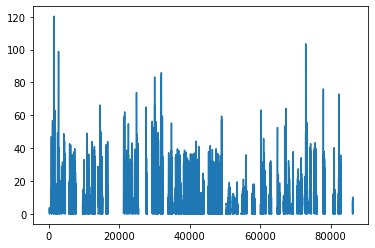

In [347]:
all_aligned_dfs['new_speed']=speed
plt.plot(speed)

In [424]:
all_aligned_dfs['dists'].columns

Index(['nose_ear_left', 'nose_ear_right', 'nose_paw_left_back',
       'nose_paw_left_front', 'nose_paw_right_back', 'nose_paw_right_front',
       'nose_tail_base', 'nose_tail_tip'],
      dtype='object')

In [459]:
df_for_training=pd.concat([all_aligned_dfs['nose']['x'],all_aligned_dfs['nose','y'],all_aligned_dfs['nose']['likelihood'],all_aligned_dfs['tail_base']['likelihood'],all_aligned_dfs['tail_tip']['likelihood'],all_aligned_dfs['new_speed']],axis=1)
df_for_training.columns=['nose_x','nose_y','nose_likelihood','tail_base_likelihood','tail_tip_likelihood','speed']

#all_aligned_dfs['dists'],
#df_for_training.columns=['nose_ear_left', 'nose_ear_right', 'nose_paw_left_back',
#       'nose_paw_left_front', 'nose_paw_right_back', 'nose_paw_right_front',
#       'nose_tail_base', 'nose_tail_tip','nose_likelihood','tail_base_likelihood','tail_tip_likelihood','speed']

In [460]:
df_for_training_annots=all_aligned_dfs.annots
df_for_training_annots

,in_light,jump,jumps,rear_supported,rear_unsupported
0,NaN,0.0,NaN,NaN,NaN
1,NaN,0.0,NaN,NaN,NaN
2,NaN,0.0,NaN,NaN,NaN
3,NaN,0.0,NaN,NaN,NaN
4,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...
86288,0.0,0.0,0.0,0.0,0.0
86289,0.0,0.0,0.0,0.0,0.0
86290,0.0,0.0,0.0,0.0,0.0
86291,0.0,0.0,0.0,0.0,0.0


In [461]:
print(np.sum(df_for_training_annots.jump))
#print(np.sum(df_for_training_annots.rear_supported))
#print(np.sum(df_for_training_annots.rear_unsupported))

4740.0


In [472]:
# scale only speed, x, y
for col in ['nose_x','nose_y','speed']:
    maxval=np.nanmax(df_for_training[col])
    df_for_training[col]=df_for_training[col]/np.nanmax(df_for_training[col])
    print(np.nanmax(df_for_training[col]))

1.0
1.0
1.0


In [473]:
xVar=df_for_training.columns
yVar=df_for_training_annots.jump
df_for_training=df_for_training.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(df_for_training, yVar, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(69034, 6) (69034,)
(17259, 6) (17259,)


# try kmeans

# TODO ADD prediction confidence

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Fit only on X_train
scaler.fit(X_train)

# Scale both X_train and X_test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(X_train)

# Scale both X_train and X_test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [474]:
X_train

,nose_x,nose_y,nose_likelihood,tail_base_likelihood,tail_tip_likelihood,speed
72871,0.797053,0.538650,0.999781,0.999736,0.995288,0.047801
42920,0.708780,0.623077,0.999282,0.999125,0.996571,0.012077
35667,0.000000,0.000000,0.006863,0.024031,0.005645,0.000000
50256,-0.000785,0.441365,0.990000,0.034904,0.006140,0.000891
21286,0.018573,0.450508,0.994691,0.062662,0.020049,0.015754
...,...,...,...,...,...,...
29745,-0.013890,0.403200,0.011950,0.869840,0.915902,0.000412
21459,-0.004999,0.802899,0.987059,0.996981,0.900884,0.012984
17841,0.000000,0.000000,0.007253,0.006809,0.007764,0.000000
60058,0.000000,0.000000,0.004138,0.006337,0.006212,0.000000


In [475]:
for n in [2,3,5,10,20]:
    classifier = KNeighborsClassifier(n_neighbors=n)
    classifier.fit(X_train, y_train)
    y_pred=classifier.predict(X_test)
    acc =  classifier.score(X_test, y_test)
    print(n,acc)

2 0.9681905092994959
3 0.9718407787241439
5 0.9719566602931804
10 0.9698128512660061
20 0.969233443420824


In [477]:
n=5
classifier = KNeighborsClassifier(n_neighbors=n)
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
acc =  classifier.score(X_test, y_test)

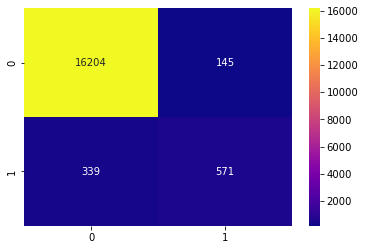

In [478]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(cm, annot=True, fmt='d',cmap='plasma');

In [479]:
colors=classifier.predict(df_for_training)

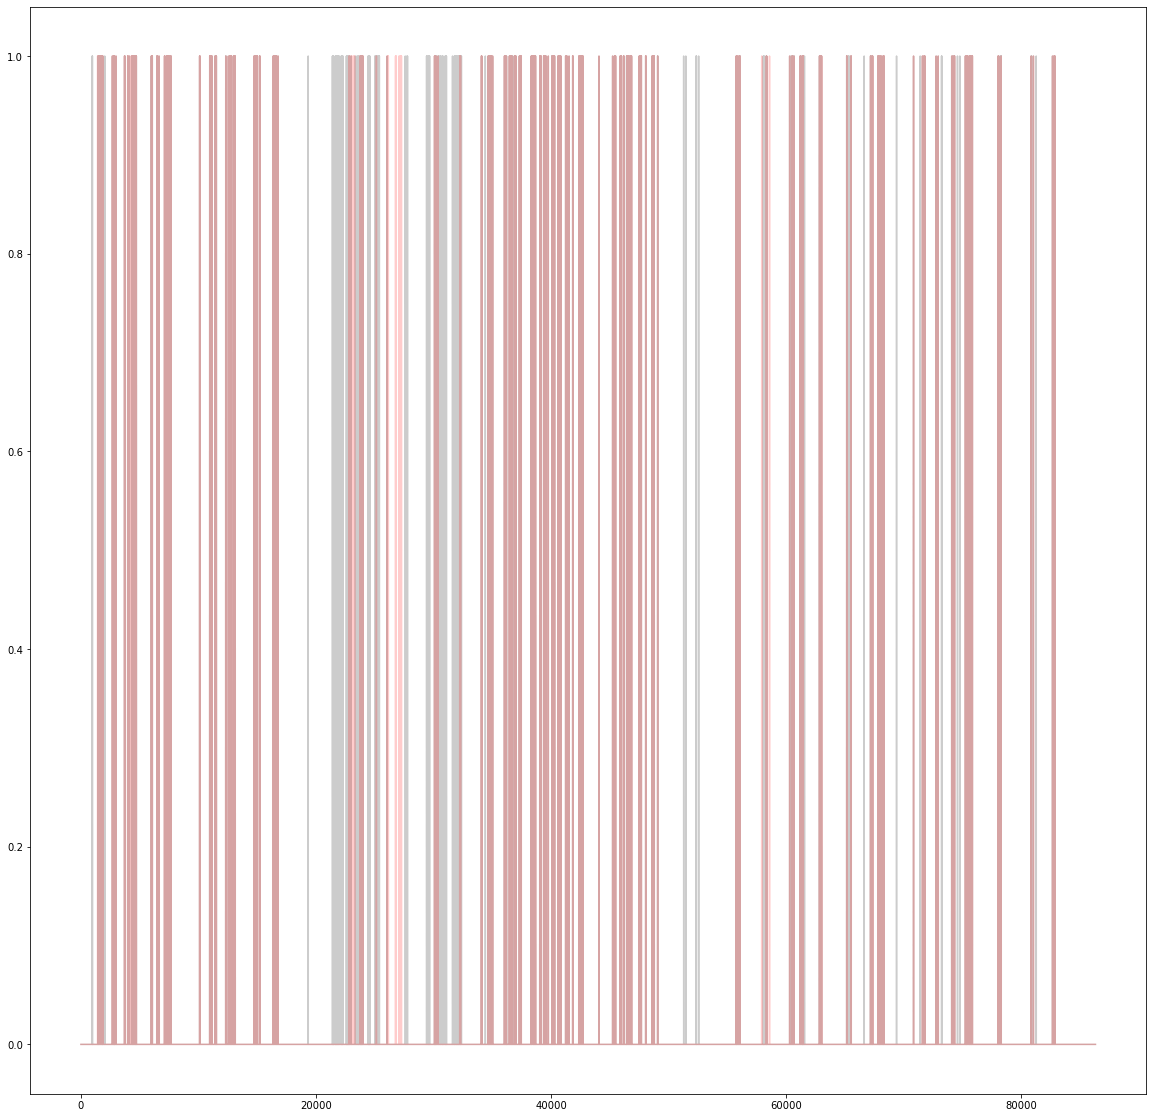

In [480]:
plt.figure(figsize=(20,20))
plt.plot(colors,'k',alpha=0.2)
plt.plot(yVar,'r',alpha=0.2)

Text(0.5, 1.0, 'predicted in dk blue')

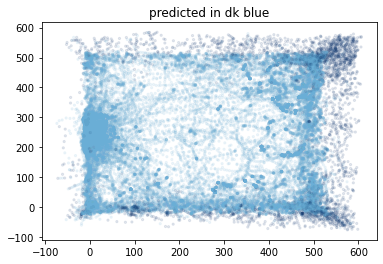

In [481]:
plt.scatter(all_aligned_dfs.nose.x,all_aligned_dfs.nose.y,c=colors,s=5,cmap="Blues",alpha=.1)
plt.clim([-1,1])
plt.title('predicted in dk blue')

Text(0.5, 1.0, 'ground truth in dark blue')

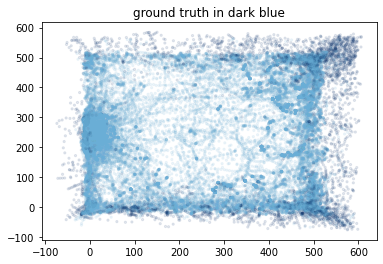

In [482]:
plt.scatter(all_aligned_dfs.nose.x,all_aligned_dfs.nose.y,c=yVar,cmap="Blues",s=5,alpha=.1)
plt.clim([-1,1])
plt.title('ground truth in dark blue')

# try random forest

In [483]:
clf = RandomForestClassifier(n_jobs=4, random_state=0)

clf.fit(X_train, y_train)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=4, oob_score=False, random_state=0,
            verbose=1, warm_start=False)

preds = clf.predict(X_test)
pd.crosstab(y_test, preds, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0.0,1.0
Actual Result,,
0.0,16248,101
1.0,277,633


In [614]:
 import joblib
joblib.dump(clf, '../data/20221219_RF_jumps.pkl') 
clf = joblib.load('../data/20221219_RF_jumps.pkl')

['../data/20221219_RF_jumps.pkl']

In [16]:
import joblib
clf = joblib.load('../data/20221219_RF_jumps.pkl')

In [17]:
#rear_unsupported_rf=clf
#rear_supported_rf=clf
#jumps_rf=clf

In [18]:
clf.predict(df_for_training.fillna(0))

NameError: name 'df_for_training' is not defined

In [ ]:
clf.

In [485]:
#aligned_df=new_aligned_df.copy()

In [486]:
#df_for_testing=pd.concat([all_aligned_dfs['dists'],all_aligned_dfs['speed']],axis=1)

In [487]:
preds_to_plot=clf.predict(df_for_training.fillna(0))

Text(0.5, 1.0, 'predicted in dark blue')

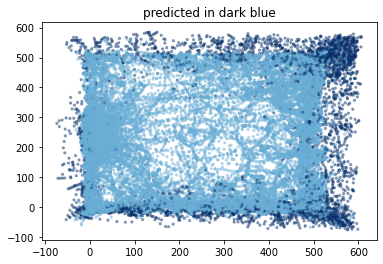

In [488]:
plt.scatter(all_aligned_dfs.nose.x,all_aligned_dfs.nose.y,c=preds_to_plot,cmap="Blues",s=5,alpha=.4)
#
plt.clim([-1,1])
plt.title('predicted in dark blue')

Text(0.5, 1.0, 'ground truth in dark blue')

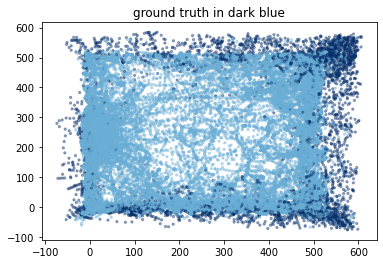

In [489]:
plt.scatter(all_aligned_dfs.nose.x,all_aligned_dfs.nose.y,c=yVar,cmap="Blues",s=5,alpha=.4)
plt.clim([-1,1])
plt.title('ground truth in dark blue')

Text(0.5, 1.0, 'predicted in yellow, ground truth in cyan')

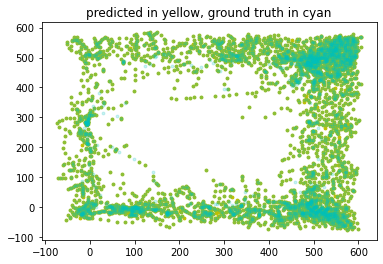

In [502]:
plt.scatter(all_aligned_dfs.nose.x[preds_to_plot==1],all_aligned_dfs.nose.y[preds_to_plot==1],c='y',s=8)
plt.scatter(all_aligned_dfs.nose.x[yVar==1],all_aligned_dfs.nose.y[yVar==1],s=8,c='c',alpha=0.2)
plt.title('predicted in yellow, ground truth in cyan')

(1250.0, 2000.0)

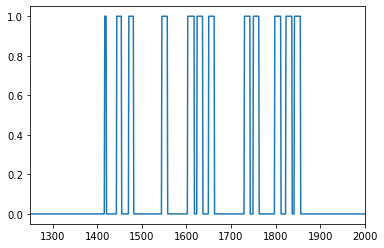

In [514]:
# number of jumps!
np.sum(all_aligned_dfs.annots['jump'])
plt.plot(all_aligned_dfs.annots['jump'])

In [563]:
jump_num=0
jumps=all_aligned_dfs.annots.jump.to_list()
jump_num_ann=np.zeros(len(jumps))

for idx in np.arange(1,len(jumps)-1):
    if jumps[idx]==1:
        if jumps[idx-1]==0:
            jump_num+=1
        jump_num_ann[idx]=jump_num
jump_num_ann[idx+1]=0

In [569]:
# how long are not-jump-intervals in alex's data?
pause_num=0
pauses=1-np.array(jumps)
pause_num_ann=np.zeros(len(pauses))

for idx in np.arange(1,len(pauses)-1):
    if pauses[idx]==1:
        if pauses[idx-1]==0:
            pause_num+=1
        pause_num_ann[idx]=pause_num
pause_num_ann[idx+1]=0

for val in np.unique(pause_num_ann):
    print(val,' | ',len(pause_num_ann[pause_num_ann==val]))

0.0  |  6158
1.0  |  23
2.0  |  16
3.0  |  63
4.0  |  45
5.0  |  6
6.0  |  13
7.0  |  67
8.0  |  7
9.0  |  35
10.0  |  11
11.0  |  5
12.0  |  806
13.0  |  69
14.0  |  45
15.0  |  8
16.0  |  14
17.0  |  105
18.0  |  709
19.0  |  24
20.0  |  223
21.0  |  7
22.0  |  105
23.0  |  143
24.0  |  39
25.0  |  8
26.0  |  40
27.0  |  78
28.0  |  9
29.0  |  14
30.0  |  12
31.0  |  50
32.0  |  13
33.0  |  22
34.0  |  1267
35.0  |  25
36.0  |  7
37.0  |  8
38.0  |  375
39.0  |  9
40.0  |  26
41.0  |  113
42.0  |  441
43.0  |  11
44.0  |  126
45.0  |  8
46.0  |  6
47.0  |  64
48.0  |  13
49.0  |  44
50.0  |  18
51.0  |  101
52.0  |  18
53.0  |  2414
54.0  |  24
55.0  |  806
56.0  |  12
57.0  |  13
58.0  |  33
59.0  |  39
60.0  |  16
61.0  |  238
62.0  |  62
63.0  |  28
64.0  |  786
65.0  |  210
66.0  |  105
67.0  |  8
68.0  |  19
69.0  |  20
70.0  |  18
71.0  |  21
72.0  |  161
73.0  |  13
74.0  |  22
75.0  |  19
76.0  |  11
77.0  |  1590
78.0  |  32
79.0  |  31
80.0  |  12
81.0  |  14
82.0  |  77
83

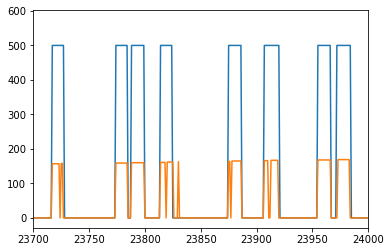

In [538]:
plt.plot(all_aligned_dfs.annots.jump*500)
plt.plot(jump_num_ann)
plt.xlim(23700,24000)
plt.show()

In [524]:
np.max(jump_num_ann) #Alex anns

343.0

In [578]:
jump_num=0
jumps=preds_to_plot
jump_num_ann_comp=np.zeros(len(jumps))

for idx in np.arange(2,len(jumps)):
    if jumps[idx]==1:
        if jumps[idx-1]==0 and jumps[idx-2]==0:
                jump_num+=1
        jump_num_ann_comp[idx]=jump_num
np.max(jump_num_ann_comp)

422.0

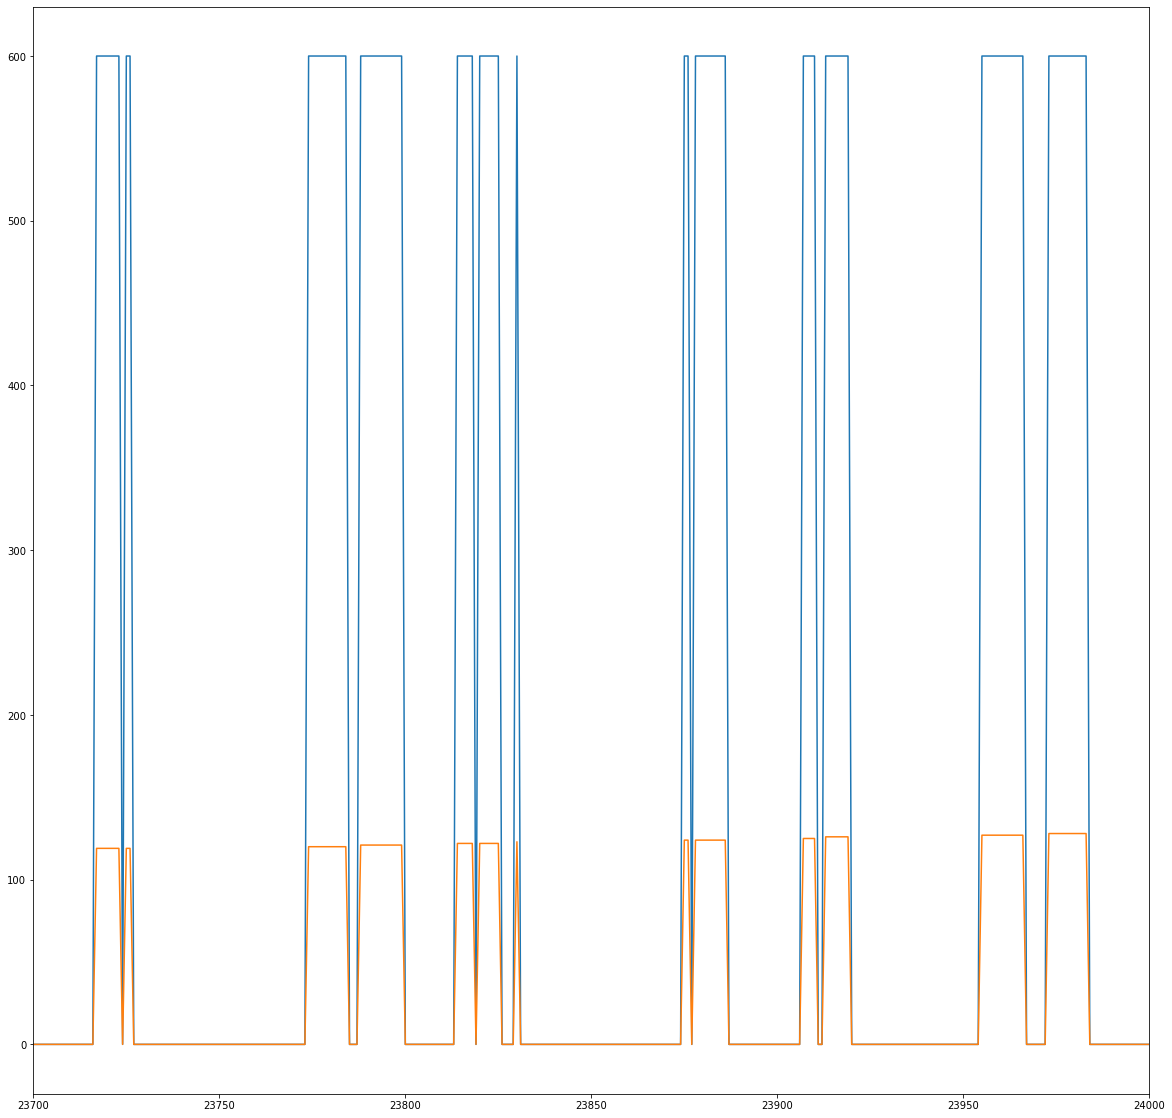

In [580]:
plt.figure(figsize=(20,20))
plt.plot(preds_to_plot*600)
plt.plot(jump_num_ann_comp)
plt.xlim(23700,24000)
plt.show()

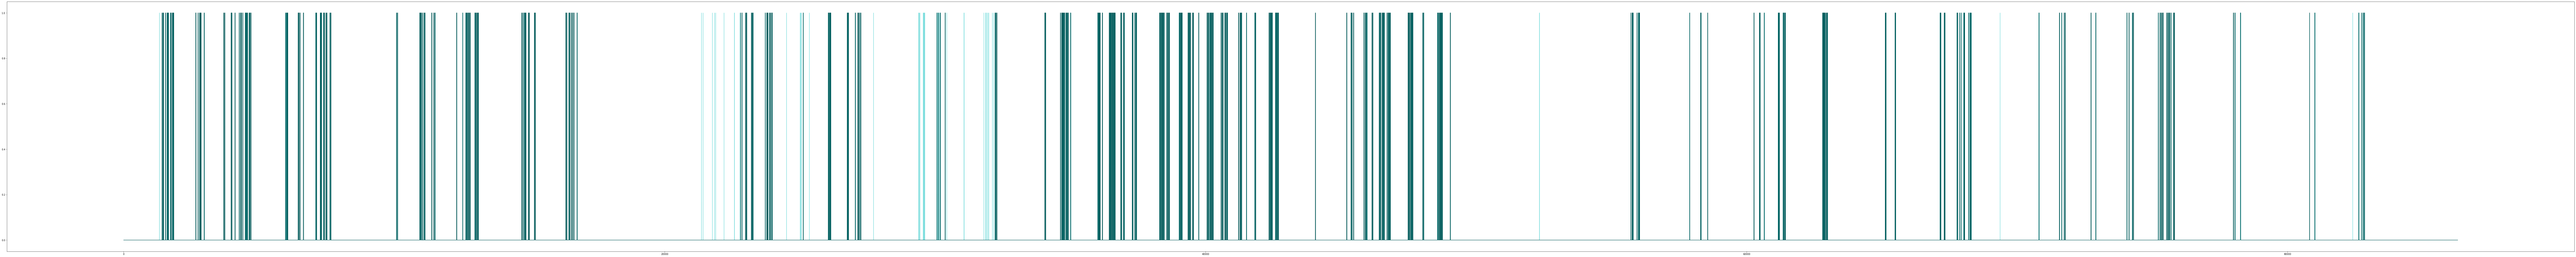

In [581]:
plt.figure(figsize=(200,20))
plt.plot(all_aligned_dfs.annots.jump.to_list(),c='k')
plt.plot(jumps,c='c',alpha=0.5)

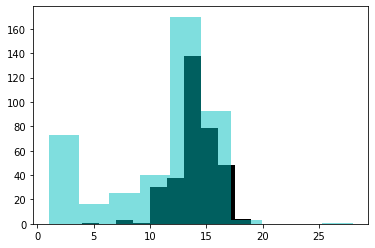

In [590]:
ann_jump_lens=[]
for val in np.arange(0,np.max(jump_num_ann)):
    ann_jump_lens.append(len(jump_num_ann[jump_num_ann==val]))
plt.hist(ann_jump_lens[1:],color='k')

comp_jump_lens=[]
for val in np.arange(0,np.max(jump_num_ann_comp)):
    comp_jump_lens.append(len(jump_num_ann_comp[jump_num_ann_comp==val]))
plt.hist(comp_jump_lens[1:],color='c',alpha=0.5)
plt.show()

In [555]:
jump_comp=pd.DataFrame(jump_num_ann,columns=['annots'])
jump_comp['preds']=jump_num_ann_comp
jump_comp[jump_comp.annots==1]

,annots,preds
1417,1.0,0.0
1418,1.0,2.0
1419,1.0,0.0
1420,1.0,3.0


In [ ]:
# smooth

423

In [591]:
np.unique(jump_num_ann_comp[comp_jump_lens>3])

TypeError: '>' not supported between instances of 'list' and 'int'

In [603]:
print(len(np.unique(jump_num_ann_comp)),' before')
for idx in np.arange(0,len(np.unique(jump_num_ann_comp))-1):
    if comp_jump_lens[idx]<4:
        print(idx)
        jump_num_ann_comp[jump_num_ann_comp==idx]=0
print(len(np.unique(jump_num_ann_comp)),' after')

423  before
1
2
16
38
69
100
101
102
103
104
105
106
107
108
116
123
129
130
131
132
133
135
139
143
146
152
153
154
155
156
157
159
160
161
163
166
167
170
171
172
173
174
175
176
177
178
179
180
181
182
184
185
189
222
290
322
323
335
341
344
352
354
361
364
373
375
378
382
384
414
415
416
419
350  after


In [492]:
#for val in all_aligned_dfs[preds_to_plot==1].index/(30*60):
#    print(val)

In [493]:
# list features, their contribution
list(zip(X_train, clf.feature_importances_))

[('nose_x', 0.21929938722868567),
 ('nose_y', 0.2099806372802956),
 ('nose_likelihood', 0.10995911930024997),
 ('tail_base_likelihood', 0.10499435298345974),
 ('tail_tip_likelihood', 0.12754552329268182),
 ('speed', 0.2282209799146273)]

In [607]:
from sklearn import tree

plt.figure(figsize=(20,20))
_=tree.plot_tree(clf.estimators_[0])
plt.savefig('/Users/dennise/Desktop/DT_jumps_for_Alex.eps')


KeyboardInterrupt



Error in callback <function flush_figures at 0x000001F9D568E040> (for post_execute):


KeyboardInterrupt: 

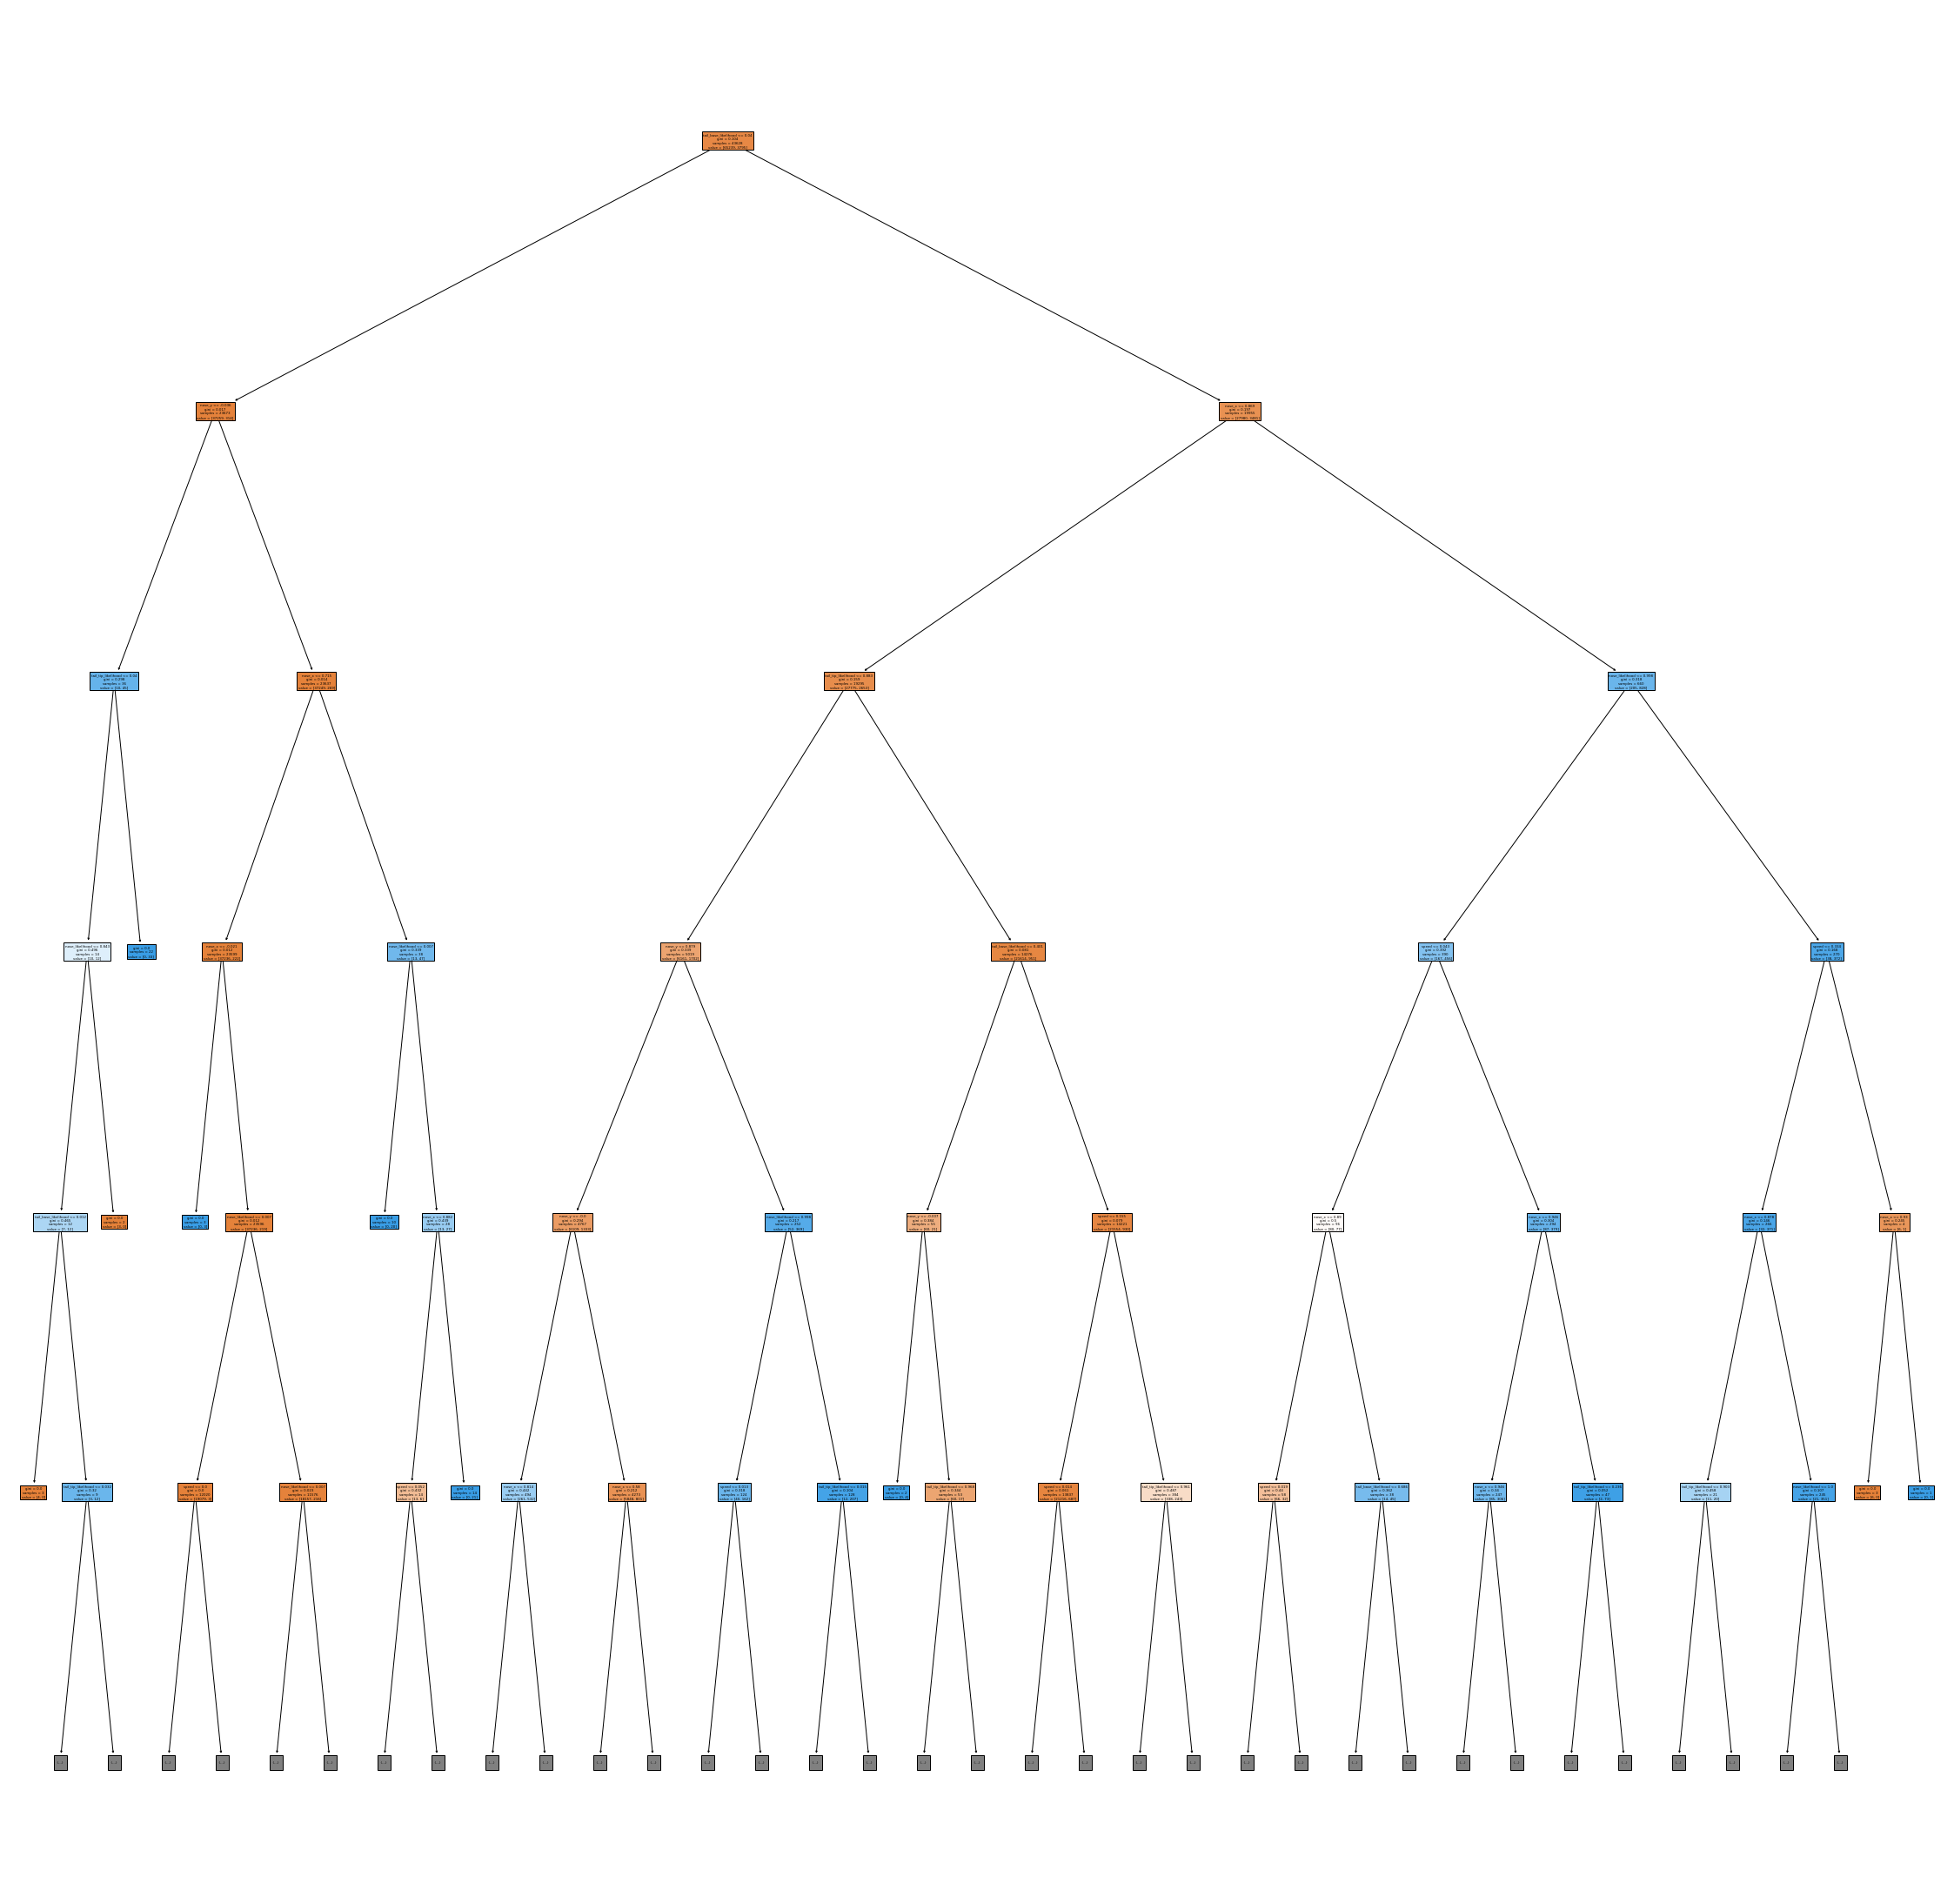

In [611]:
plt.figure(figsize=(40,40))
_ = tree.plot_tree(clf.estimators_[2], feature_names=X_train.columns, filled=True,max_depth=5)
plt.savefig('/Users/dennise/Desktop/DT_jumps_for_Alex_TOP5.png')

# TODOs
- add classifier output to csv, save out
- add Alex to lab GitHub
- turn into scripts
- check additional ground truth data
- if looks good and Alex is happy, process all the videos
    - DLC analysis of video
    - run script on each output csv
    - send to Alex

# notes from Alex chat 20221125
- observer quant I need to annotate some
- re run on all the data we have
- send alex just-jumps
- Alex owes me videos and start times

In [173]:
# consider tortuosity of trajectory, speed profile

In [29]:
emily_anns = pd.read_csv('../data/video_anns_emily.csv')
emily_anns

,video,behavior,start_or_stop,time_in_sec,encdoed_FPS
0,5,nose_in,1.0,17.281,29.917
1,5,ears_in,1.0,18.551,NaN
2,5,ears_in,0.0,19.654,NaN
3,5,nose_in,0.0,20.122,NaN
4,5,nose_in,1.0,31.086,NaN
...,...,...,...,...,...
524,39,jump,0.0,546.314,NaN
525,39,jump,1.0,546.715,NaN
526,39,jump,0.0,547.149,NaN
527,39,jump,1.0,556.572,NaN


In [30]:
rows_to_rm=[]
emily_anns['frame']=float(0)
fps = emily_anns.encdoed_FPS[0]
for idx in emily_anns.index:
    #print(idx)
    if np.isnan(emily_anns.encdoed_FPS[idx]):
        emily_anns.encdoed_FPS[idx]=fps
    else:
        fps = emily_anns.encdoed_FPS[idx]
    emily_anns.iloc[idx,-1]=emily_anns.time_in_sec[idx]*fps
    if np.isnan(emily_anns.start_or_stop[idx]):
        rows_to_rm.append(idx)
    elif "_in" in emily_anns.behavior[idx]:
        rows_to_rm.append(idx)


C:\Users\dennise\AppData\Local\Temp\ipykernel_15212\1030031883.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emily_anns.encdoed_FPS[idx]=fps


In [31]:
emily_anns.drop(emily_anns.index[rows_to_rm], inplace=True)
emily_anns=emily_anns.reset_index().drop(columns='index')
emily_anns

,video,behavior,start_or_stop,time_in_sec,encdoed_FPS,frame
0,5,rear_supported,1.0,71.063,29.917,2125.991771
1,5,rear_supported,0.0,71.698,29.917,2144.989066
2,5,rear_supported,1.0,72.300,29.917,2162.999100
3,5,rear_supported,0.0,73.403,29.917,2195.997551
4,5,rear_supported,1.0,74.907,29.917,2240.992719
...,...,...,...,...,...,...
417,39,jump,0.0,546.314,29.926,16348.992764
418,39,jump,1.0,546.715,29.926,16360.993090
419,39,jump,0.0,547.149,29.926,16373.980974
420,39,jump,1.0,556.572,29.926,16655.973672


In [32]:
emily_anns.to_csv('../data/video_anns_emily_cleaned.csv')

In [33]:
emily_anns

,video,behavior,start_or_stop,time_in_sec,encdoed_FPS,frame
0,5,rear_supported,1.0,71.063,29.917,2125.991771
1,5,rear_supported,0.0,71.698,29.917,2144.989066
2,5,rear_supported,1.0,72.300,29.917,2162.999100
3,5,rear_supported,0.0,73.403,29.917,2195.997551
4,5,rear_supported,1.0,74.907,29.917,2240.992719
...,...,...,...,...,...,...
417,39,jump,0.0,546.314,29.926,16348.992764
418,39,jump,1.0,546.715,29.926,16360.993090
419,39,jump,0.0,547.149,29.926,16373.980974
420,39,jump,1.0,556.572,29.926,16655.973672


In [114]:
# working on transitioning to script, need to test out loading pkl file, using to predict on a df.
df = pd.read_csv('../data/39DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000_aligned_dists.csv',header=[0,1])
df

Unnamed: 0_level_0        box_bl                   box_br         \
      Unnamed: 0_level_1             x      y likelihood      x      y   
0                      0  0.000000e+00  500.0   0.999807  500.0  500.0   
1                      1  0.000000e+00  500.0   0.999832  500.0  500.0   
2                      2  0.000000e+00  500.0   0.999849  500.0  500.0   
3                      3  0.000000e+00  500.0   0.999859  500.0  500.0   
4                      4  5.760037e-14  500.0   0.999788  500.0  500.0   
...                  ...           ...    ...        ...    ...    ...   
17959              17959  0.000000e+00  500.0   0.999835  500.0  500.0   
17960              17960  5.812110e-14  500.0   0.999849  500.0  500.0   
17961              17961  0.000000e+00  500.0   0.999856  500.0  500.0   
17962              17962  0.000000e+00  500.0   0.999817  500.0  500.0   
17963              17963  1.162559e-13  500.0   0.999817  500.0  500.0   

                        box_tl                           ...   tail_tip  \
      likelihood             x             y likelihood  ... likelihood   
0       0.999425  0.000000e+00  7.117104e-15   0.999978  ...   0.293948   
1       0.999105  0.000000e+00  7.117825e-15   0.999977  ...   0.310536   
2       0.998960  5.693558e-14 -7.116947e-15   0.999986  ...   0.326454   
3       0.999381  1.138557e-13  0.000000e+00   0.999985  ...   0.276298   
4       0.999701  0.000000e+00  7.115562e-15   0.999982  ...   0.239869   
...          ...           ...           ...        ...  ...        ...   
17959   0.999936  5.755170e-14  1.438793e-14   0.999932  ...   0.040843   
17960   0.999925  5.755086e-14  0.000000e+00   0.999925  ...   0.078385   
17961   0.999932  5.755119e-14  0.000000e+00   0.999916  ...   0.117359   
17962   0.999890  5.755169e-14 -7.193961e-15   0.999898  ...   0.055927   
17963   0.999934  0.000000e+00  0.000000e+00   0.999898  ...   0.058966   

               dists                                                       \
      nose_ear_right nose_ear_left nose_paw_left_back nose_paw_left_front   
0                NaN           NaN                NaN                 NaN   
1                NaN           NaN                NaN                 NaN   
2                NaN           NaN                NaN                 NaN   
3                NaN           NaN                NaN                 NaN   
4                NaN           NaN                NaN                 NaN   
...              ...           ...                ...                 ...   
17959      18.629486     17.189996                NaN                 NaN   
17960      21.536389     19.701003                NaN                 NaN   
17961      22.463593     20.914205                NaN                 NaN   
17962      22.421172     21.231541                NaN                 NaN   
17963      22.592457     21.214203                NaN                 NaN   

                                                                             \
      nose_paw_right_back nose_paw_right_front nose_tail_tip nose_tail_base   
0                     NaN                  NaN           NaN            NaN   
1                     NaN                  NaN           NaN            NaN   
2                     NaN                  NaN           NaN            NaN   
3                     NaN                  NaN           NaN            NaN   
4                     NaN                  NaN           NaN            NaN   
...                   ...                  ...           ...            ...   
17959                 NaN                  NaN           NaN            NaN   
17960           39.456385                  NaN           NaN            NaN   
17961           40.143779                  NaN           NaN            NaN   
17962           40.469550                  NaN           NaN            NaN   
17963           39.421078                  NaN           NaN            NaN   

                    speed  
      Unn

In [118]:
aligned_df=df.copy()
df_for_training=pd.concat([aligned_df['nose']['x'],aligned_df['nose','y'],aligned_df['nose']['likelihood'],aligned_df['tail_base']['likelihood'],aligned_df['tail_tip']['likelihood'],aligned_df['speed']],axis=1)
df_for_training.columns=['nose_x','nose_y','nose_likelihood','tail_base_likelihood','tail_tip_likelihood','speed']

In [120]:
for col in ['nose_x','nose_y','speed']:
    maxval=np.nanmax(df_for_training[col])
    df_for_training[col]=df_for_training[col]/np.nanmax(df_for_training[col])

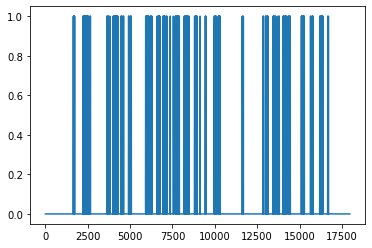

In [124]:
plt.plot(clf.predict(df_for_training.fillna(0)))

In [136]:
'../data/'

NameError: name '__file__' is not defined

In [9]:
column_vals=['sub_file_name','total_frames','num_entrances','first_frame_in_center','frames_with_nose','frames_with_head','frames_with_body','frames_within_50mm','fraction_frames_within_50mm','fraction_LIGHT_frames_within_50mm','fraction_LIGHT_frames_in_center','num_jumps']

In [22]:
full_path_list=['tst','2']
total_frames=[0,1]
num_entrances=[1,2]
first_frame_in_center=[2,2]
frames_with_nose=[3,3]
frames_with_head=[4,4]
frames_with_body=[5,10]
frames_within_50mm=[6,12]
fraction_frames_within_50mm=[.7,.7]
fraction_LIGHT_frames_within_50mm=[.8,.8]
fraction_LIGHT_frames_in_center=[.9,.9]
num_jumps=[10,10]

In [27]:
zipped=zip(full_path_list,total_frames,num_entrances,first_frame_in_center,frames_with_nose,frames_with_head,frames_with_body,frames_within_50mm, fraction_frames_within_50mm,fraction_LIGHT_frames_within_50mm,fraction_LIGHT_frames_in_center,num_jumps)
zipped

In [28]:
pd.DataFrame(zipped,columns=column_vals)

,sub_file_name,total_frames,num_entrances,first_frame_in_center,frames_with_nose,frames_with_head,frames_with_body,frames_within_50mm,fraction_frames_within_50mm,fraction_LIGHT_frames_within_50mm,fraction_LIGHT_frames_in_center,num_jumps
0,tst,0,1,2,3,4,5,6,0.7,0.8,0.9,10
1,2,1,2,2,3,4,10,12,0.7,0.8,0.9,10


In [30]:
import numpy as np

In [34]:
zipped=zip(['C:\\Users\\dennise\\Desktop\\AlexF\\VID_20210925_134723DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000.csv'],[17957],[30.0],[446],[9442],[9086],[8702],[],[0.44244584284680066],[np.array([0.84145308])],[np.array([0.15854692])],[188.0])

In [35]:
pd.DataFrame(zipped,columns=column_vals)

,sub_file_name,total_frames,num_entrances,first_frame_in_center,frames_with_nose,frames_with_head,frames_with_body,frames_within_50mm,fraction_frames_within_50mm,fraction_LIGHT_frames_within_50mm,fraction_LIGHT_frames_in_center,num_jumps
0,C:\Users\dennise\Desktop\AlexF\VID_20210925_13...,17957,30.0,446,9442,9086,8702,1,0.442446,[0.84145308],[0.15854692],188.0


In [41]:
jump_bouts=[0,0,0,0,0,1,1,0,0,0,20,20,20,20,20,20,20,20,0,0,0,0,0,23,23,0,0,0,0,0,0,0,0]



2